# VarClump2D: Concept test

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

## Loading data 2D: Stacked on frequency

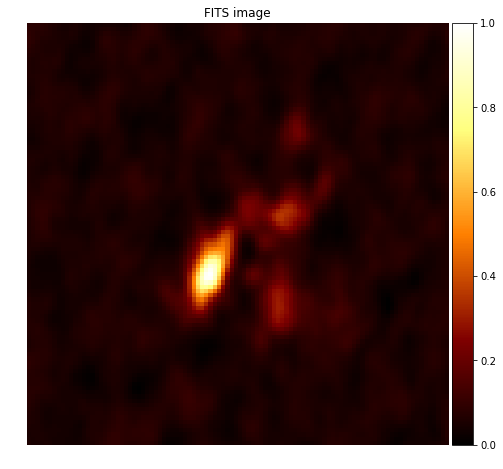

In [2]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/home/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.thresholded_image_plot>

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^2} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^2}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i,y_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Center points generation 

In [5]:
# number of points of each type
Nb = 0
Nc = 300
Ne = 4*Nc-4*Nb

In [6]:
base_level = estimate_rms(data)

##########################################
# Approach 1
##########################################

center_points = random_centers_generation(data, Nc, base_level=base_level, power=7.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)


##########################################
# Approach 2
##########################################

# collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
# center_points = collocation_points[0:Nc]
# boundary_points = boundary_generation(Nb)



##########################################
# Approach 3
##########################################

# points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
# center_points = points[0:Nc]
# collocation_points = points[Nc:Nc+Ne]
# boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

***
### Boundary Points Generation
***

In [7]:
def boundary_map(data, base_level):
    pixel_map = data > base_level
    m,n = pixel_map.shape
    border_map = np.zeros((m,n), dtype=bool)
    for i in range(m):
        for j in range(n):
            # just verify valid pixels
            if pixel_map[i,j]==False: continue
            for p in range(-1,2):
                for q in range(-1,2):
                    if p==q==0: continue
                    if i+p < 0 or j+q < 0: continue
                    if i+p >= m or j+q >= n: continue
                    # in case pixel_map[i,j] has a unusable neighbor pixel
                    # then pixel_map[i,j] is a border pixel
                    if pixel_map[i+p,j+q]==False: border_map[i,j] = True
    return border_map

def boundary_points_generation(data, base_level, n_points):
    border_map = boundary_map(data, base_level)
    x_pos, y_pos = np.where(border_map)
    # mapping to [0,1] range
    x_pos = x_pos.astype(float)
    y_pos = y_pos.astype(float)
    x_pos /= float(data.shape[0]); x_pos += 0.5/data.shape[0]
    y_pos /= float(data.shape[1]); y_pos += 0.5/data.shape[1]
    boundary_points =  np.vstack([x_pos, y_pos]).T
    # random selecting the specified number of points
    if n_points > boundary_points.shape[0]:
        print("Number of can't be greater than the number of border pixels")
        return None
    np.random.seed(0)
    points_indexes = np.arange(boundary_points.shape[0])
    selected = np.random.choice(points_indexes, size=n_points)
    return boundary_points[selected]

In [8]:
border_map = boundary_map(data, base_level)
boundary_points = boundary_points_generation(data, base_level, 100)

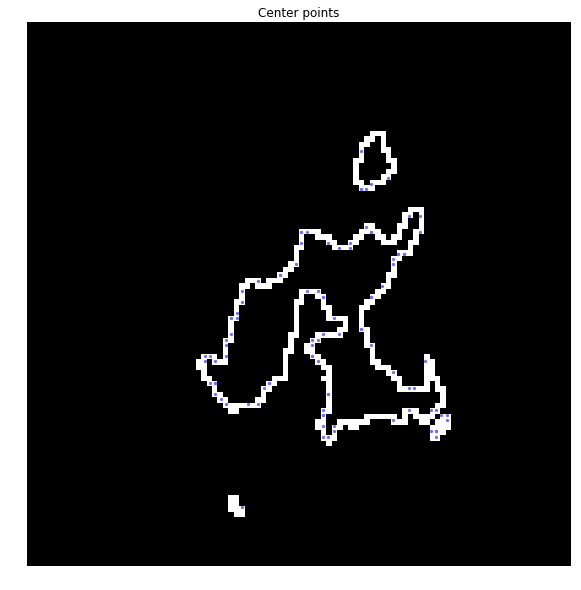

In [9]:
points_plot(border_map, center_points=boundary_points)

### Visualization of points

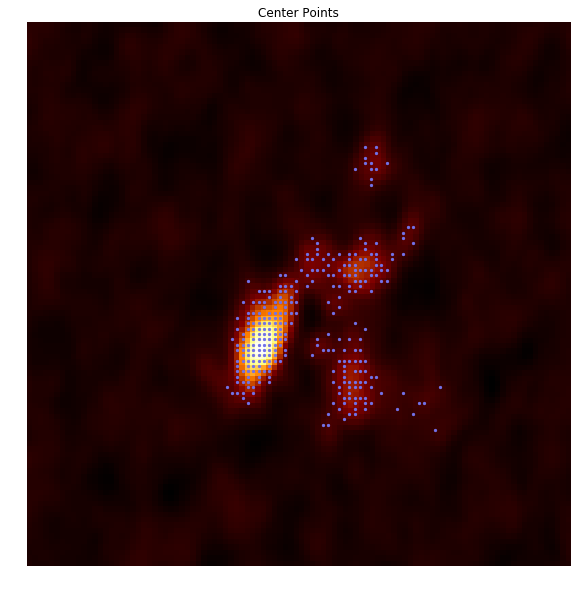

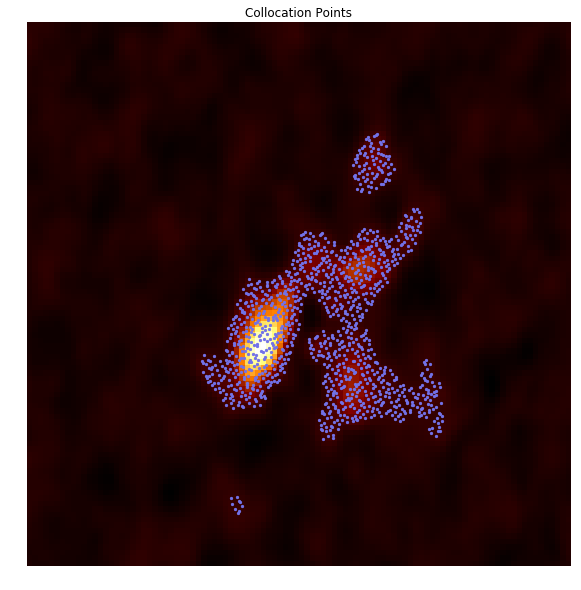

In [10]:
# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")

## Initial Conditions

In [21]:
####################################
# Initial parameters estimation
####################################

#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)

# Experiments: With  `base_level=RMS`
The following instances are tests with different settings combinations for: square_c

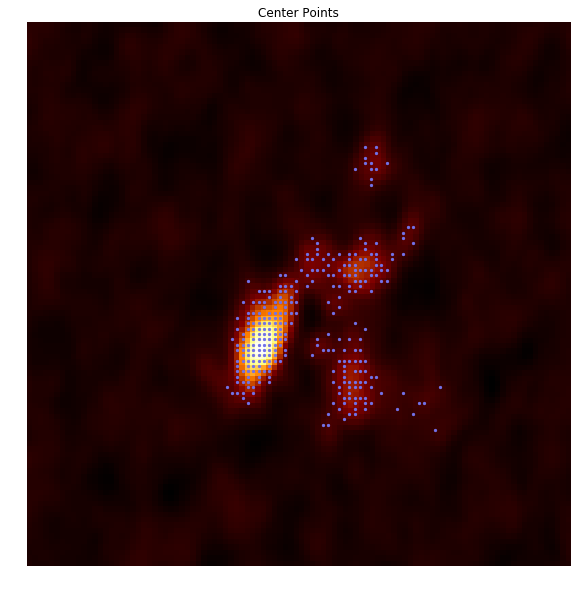

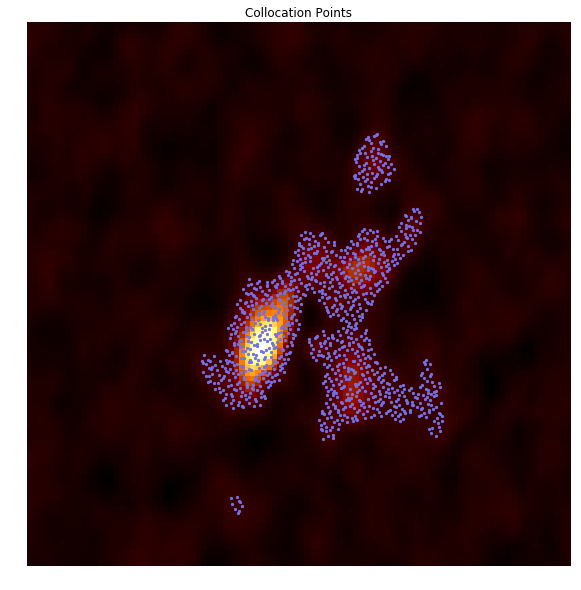

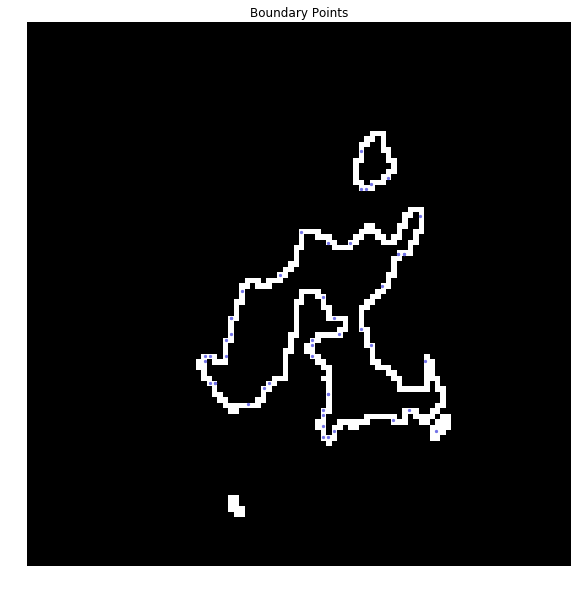

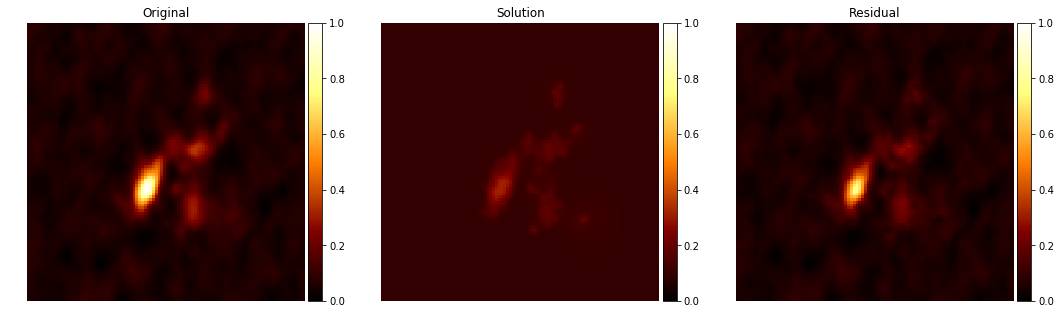

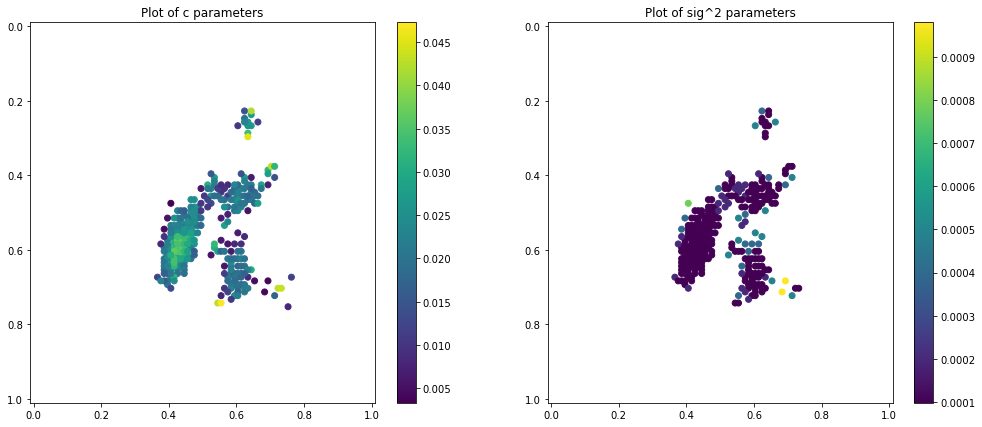

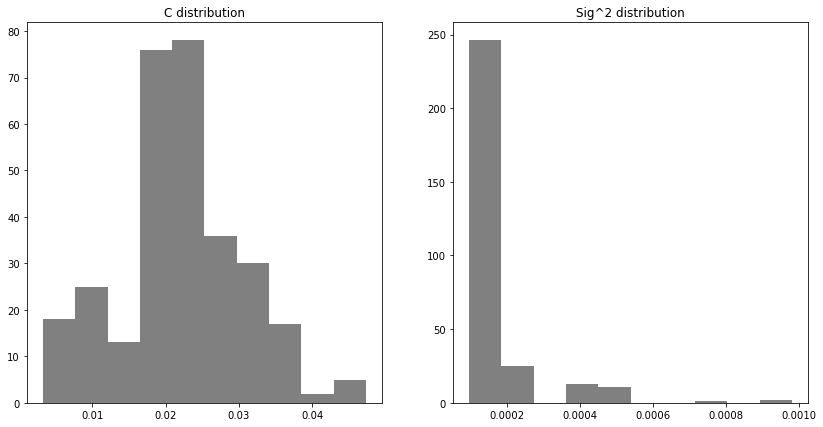

In [15]:
##########################################
# Approach 1
##########################################

# number of points of each type
Nb = 50
Nc = 300
Ne = 4*Nc-Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=7.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(boundary_map(data, base_level), center_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120114

Residual stats:
Residual RMS: 0.10106900819851061
Residual Variance: 1.9673516391219437e-05
Residual Entropy: 7.130657362340785
Total elapsed time: 426.95400190353394 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.21176578487042874
Mean min distance between collocation and center points: 0.01198060844343883

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.07090770597635529
Max min distance in the (standarized) parameters space: 0.5038711423804834


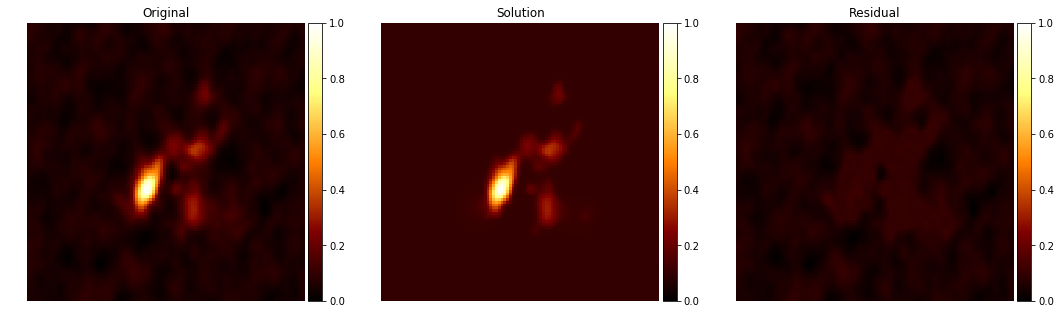

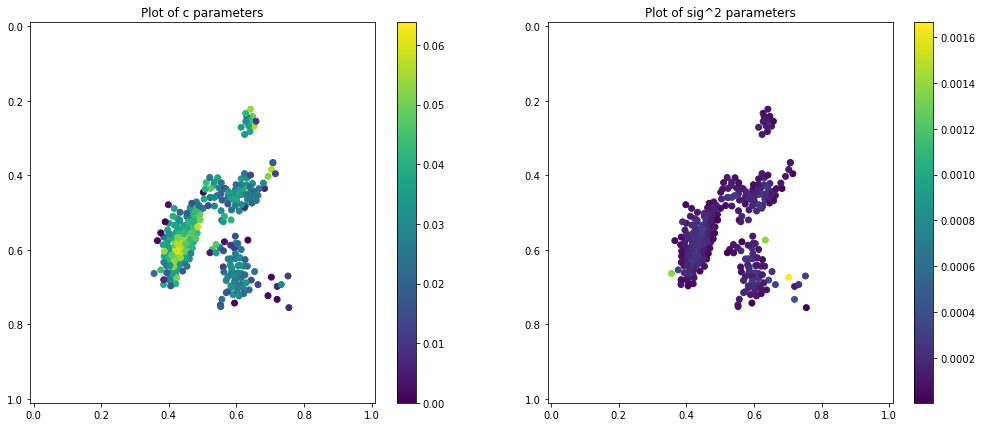

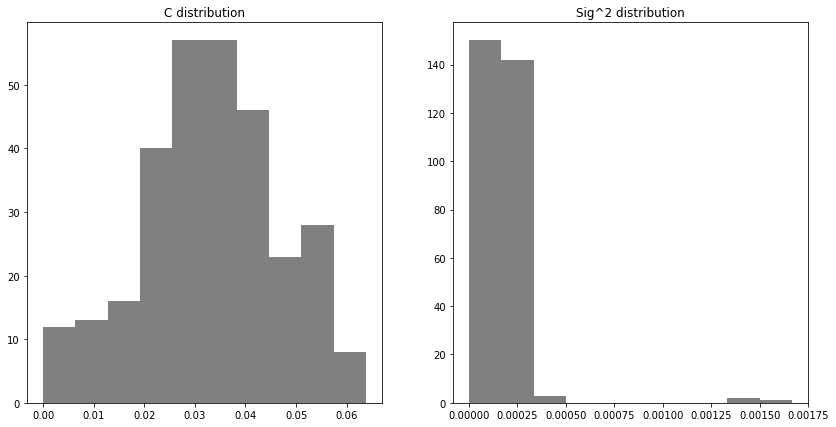

In [16]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [19]:
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

components_dict01 = gaussian_reduction(w, mu, sig, n_comp=1, verbose=False)

In [20]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/home/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>

***

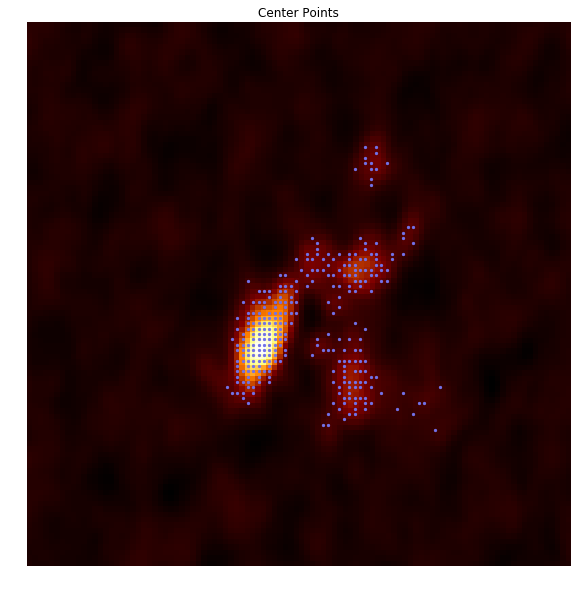

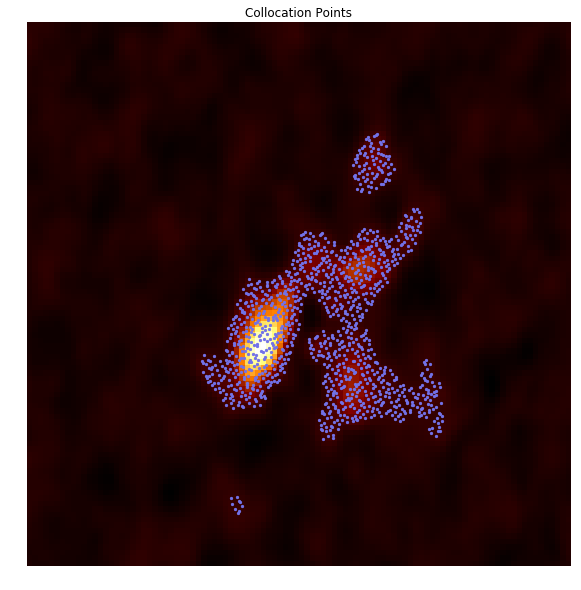

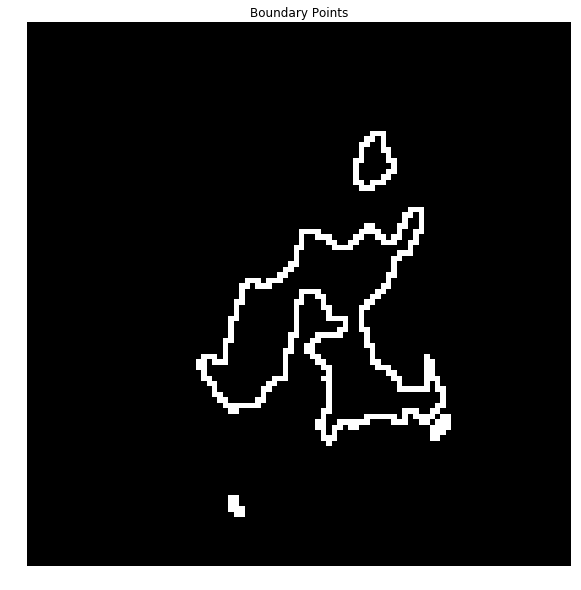

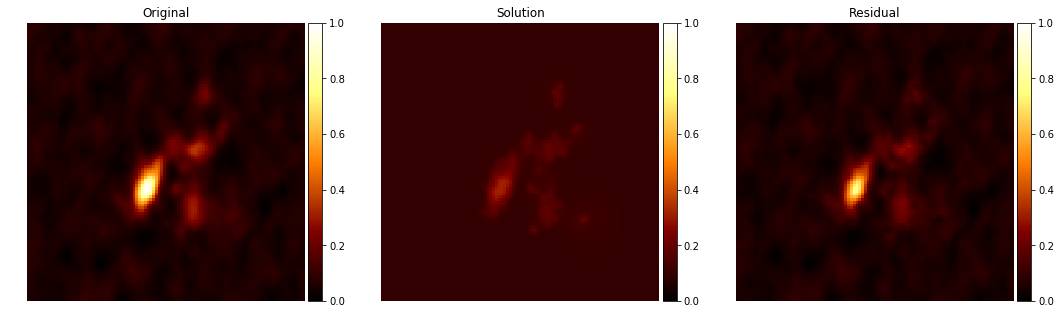

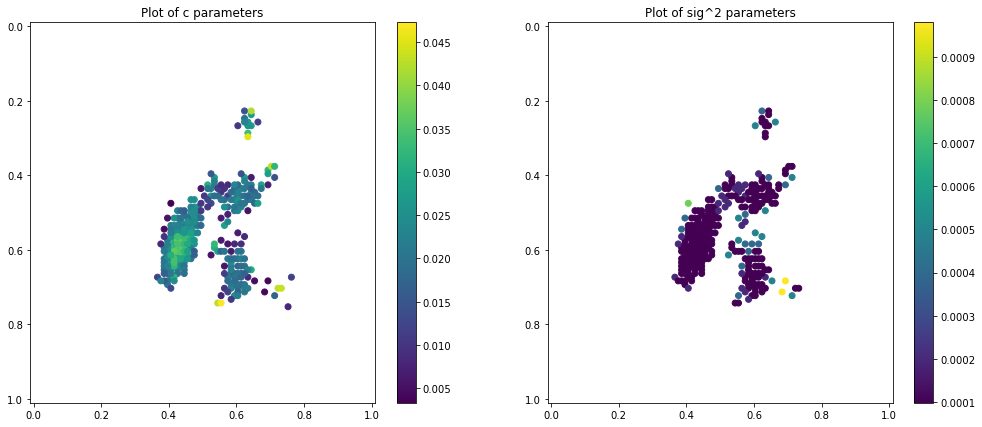

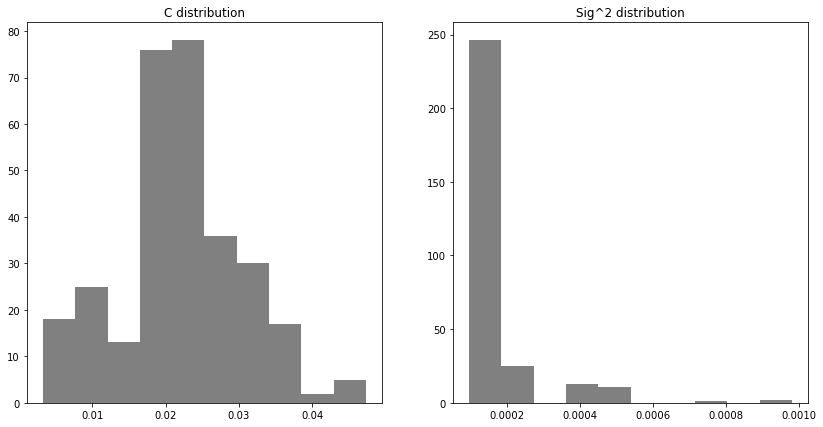

In [25]:
##########################################
# Approach 1
##########################################

# number of points of each type
Nb = 0
Nc = 300
Ne = 4*Nc-Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=7.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(boundary_map(data, base_level), center_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm02 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120110

Residual stats:
Residual RMS: 0.10109171459467899
Residual Variance: 1.938922028120713e-05
Residual Entropy: 7.110656265384394
Total elapsed time: 398.42706179618835 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.20801635289979234
Mean min distance between collocation and center points: 0.011777954885785931

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06818455120478721
Max min distance in the (standarized) parameters space: 0.4372199821583475


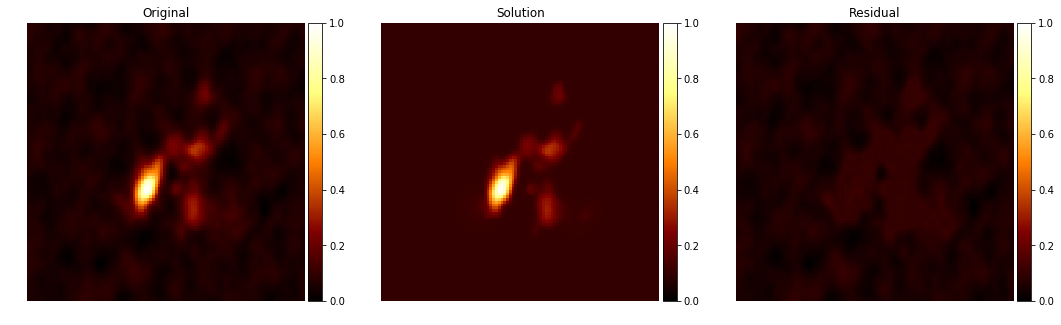

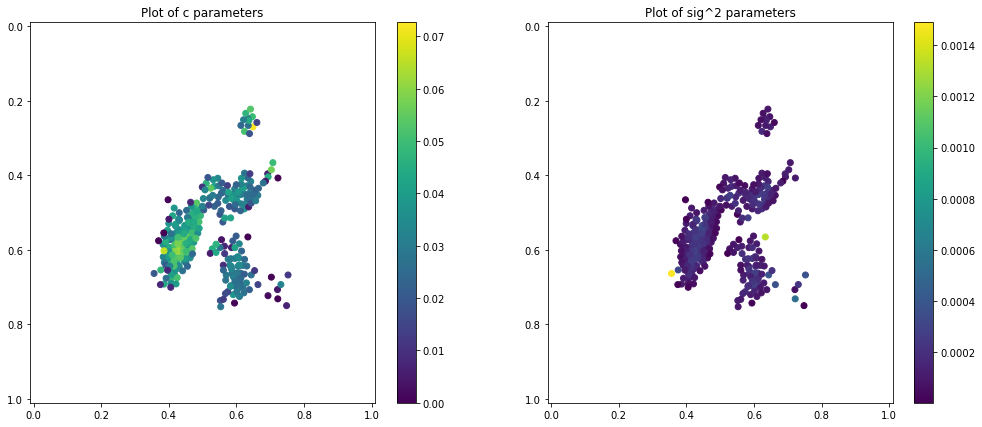

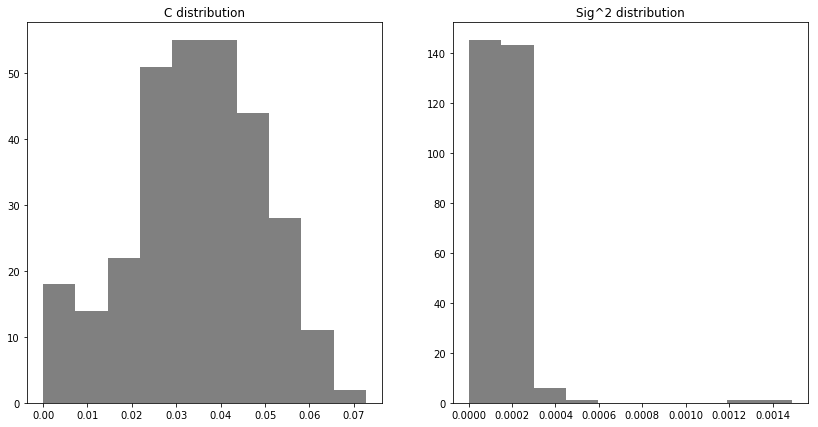

In [26]:
nfev = 100*(len(elm02.get_params())+1)
elm_solver(elm02, method='standard', max_nfev=nfev)

In [27]:
# gaussian agglomeration
xc, yc, c, sig = elm02.get_params_mapped()
mu = np.vstack([xc, yc]).T

components_dict02 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 209 and 294 with 1.208809681399049e-13 dissimilarity
Merged components 171 and 284 with 3.9475815133294804e-07 dissimilarity
Merged components 263 and 285 with 1.434001237185298e-06 dissimilarity
Merged components 292 and 293 with 3.505606587987306e-06 dissimilarity
Merged components 292 and 295 with 3.9913383613691955e-05 dissimilarity
Merged components 182 and 220 with 0.00016848689077919587 dissimilarity
Merged components 165 and 249 with 0.0007664288272906106 dissimilarity
Merged components 66 and 68 with 0.0008004784380166441 dissimilarity
Merged components 64 and 190 with 0.000854444187167791 dissimilarity
Merged components 91 and 110 with 0.0008890631084615963 dissimilarity
Merged components 34 and 165 with 0.0009260088775052688 dissimilarity
Merged components 104 and 174 with 0.0010604465532349505 dissimilarity
Merged components 57 and 118 with 0.00107823869169191 dissimilarity
Merged components 68 and 153 with 0.001526676880680311 dissimilarity
Merged compone

In [28]:
interact(components_plot, elm=fixed(elm02), data=fixed(data), components_dict=fixed(components_dict02), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/home/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>

***
***
***
***
***
### Alternative approach test

In [20]:
elm020 = copy.deepcopy(elm02)
elm021 = copy.deepcopy(elm02)
elm022 = copy.deepcopy(elm02)
elm023 = copy.deepcopy(elm02)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 1211

Residual stats:
Residual RMS: 0.101098169582
Residual Variance: 2.14959891631e-05
Residual Entropy: 7.10288038822
Total elapsed time: 15.0084900856 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.197245840761
Mean min distance between collocation and center points: 0.0122521778875

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0704722354973
Max min distance in the (standarized) parameters space: 0.577177992191


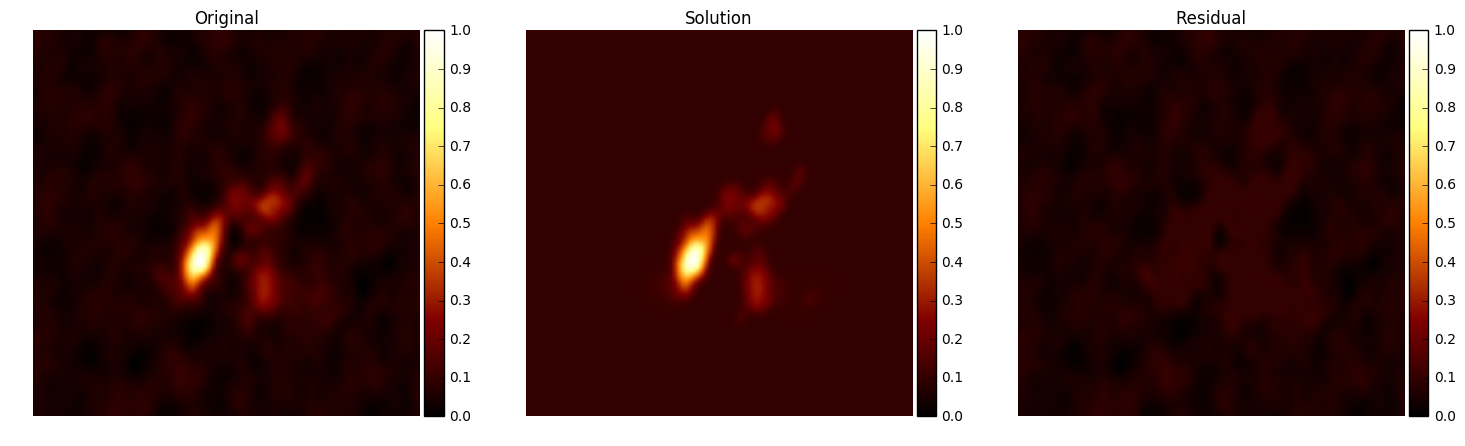

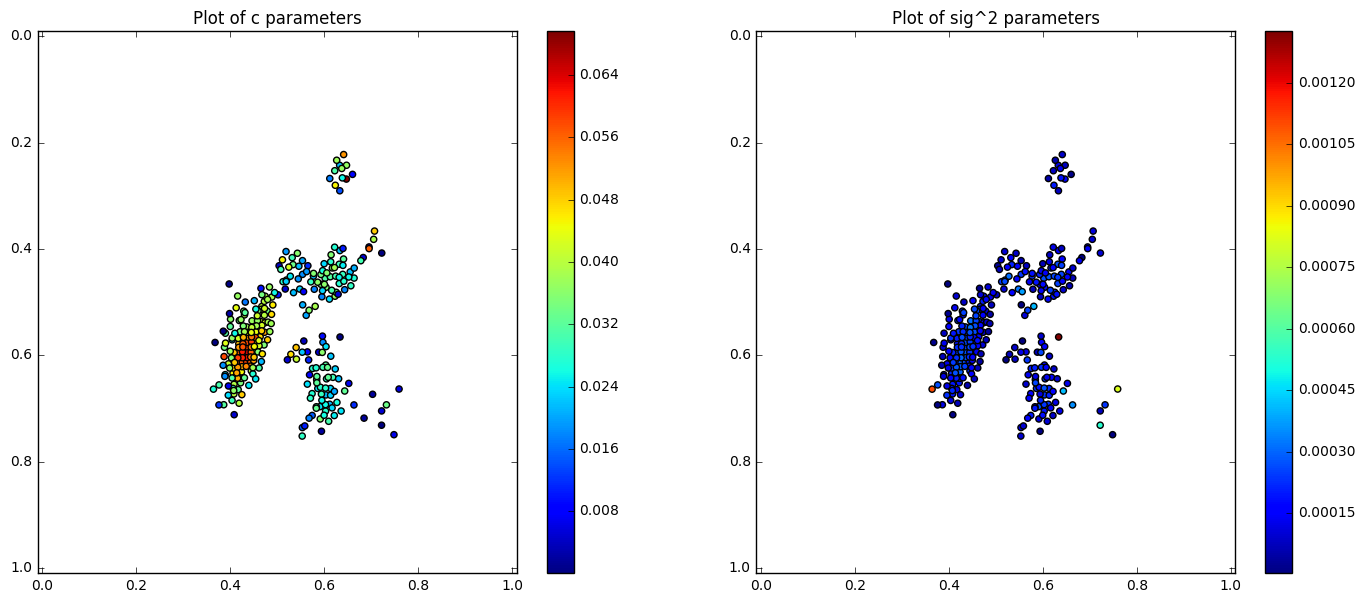

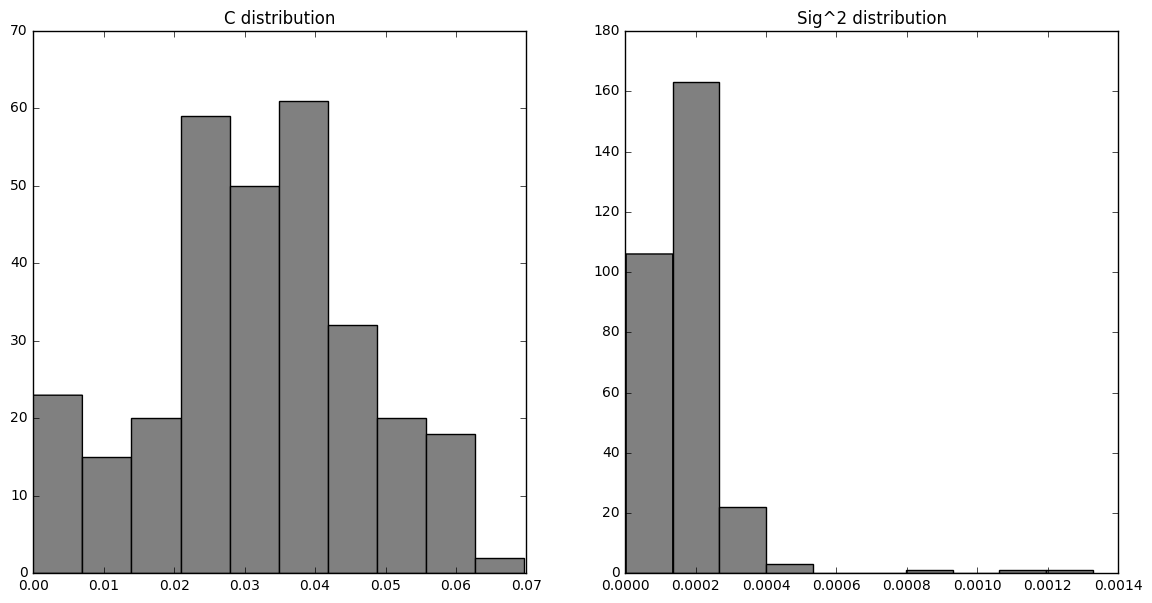

In [21]:
elm_solver(elm020, method='standard', max_nfev=nfev, xtol=1e-7, ftol=1e-7)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 1212

Residual stats:
Residual RMS: 0.101098169582
Residual Variance: 2.14959891631e-05
Residual Entropy: 7.10288038822
Total elapsed time: 15.3012750149 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.197245840761
Mean min distance between collocation and center points: 0.0122521778875

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0704722354973
Max min distance in the (standarized) parameters space: 0.577177992191


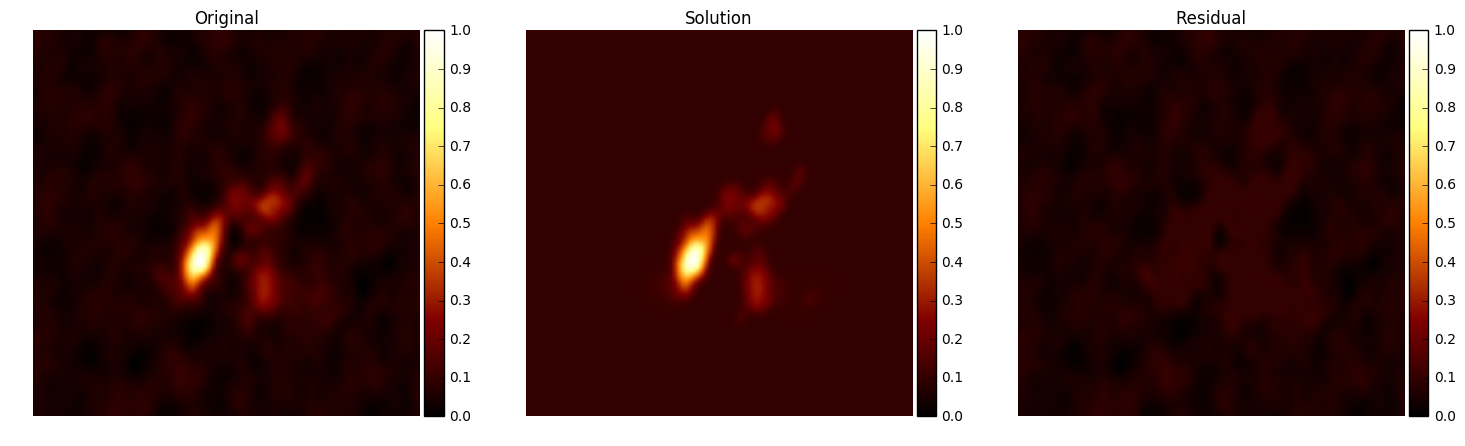

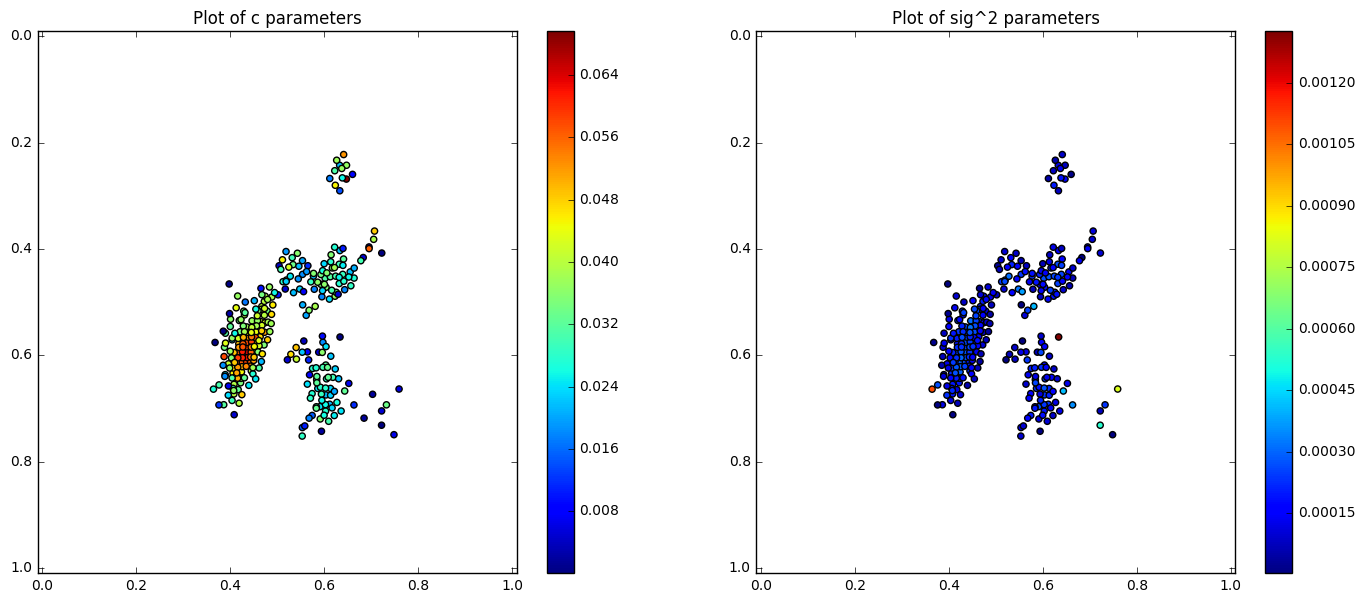

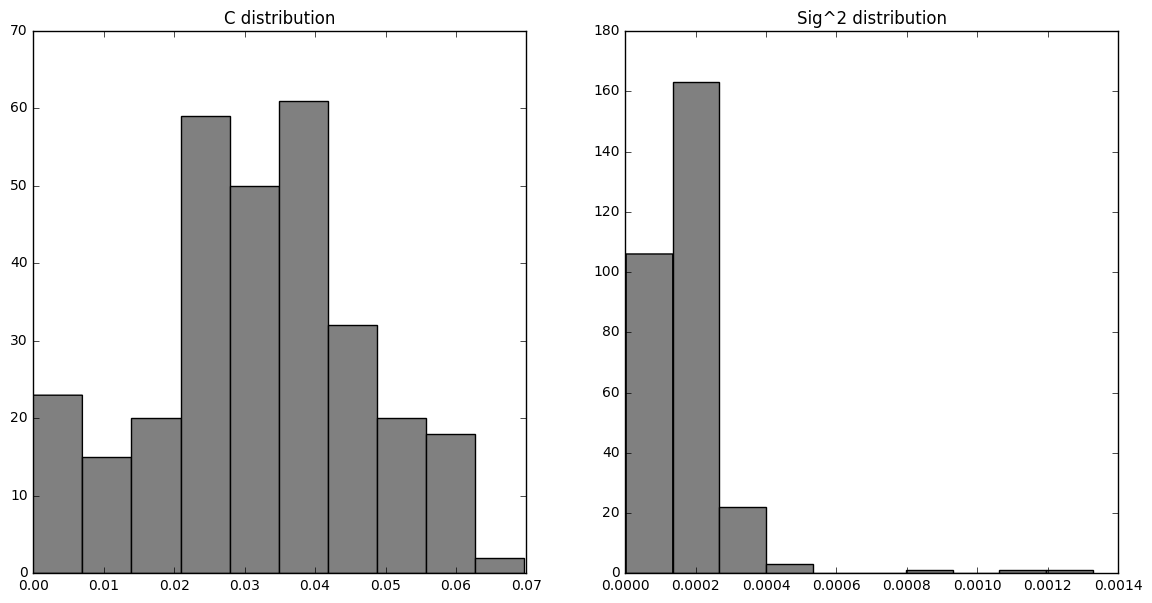

In [22]:
elm_solver(elm021, method='standard', max_nfev=nfev, xtol=1e-8, ftol=1e-8)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 1213

Residual stats:
Residual RMS: 0.101098169413
Residual Variance: 2.1495988204e-05
Residual Entropy: 7.10288038822
Total elapsed time: 15.6061758995 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.197245839811
Mean min distance between collocation and center points: 0.0122523296679

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.070480121528
Max min distance in the (standarized) parameters space: 0.577179479104


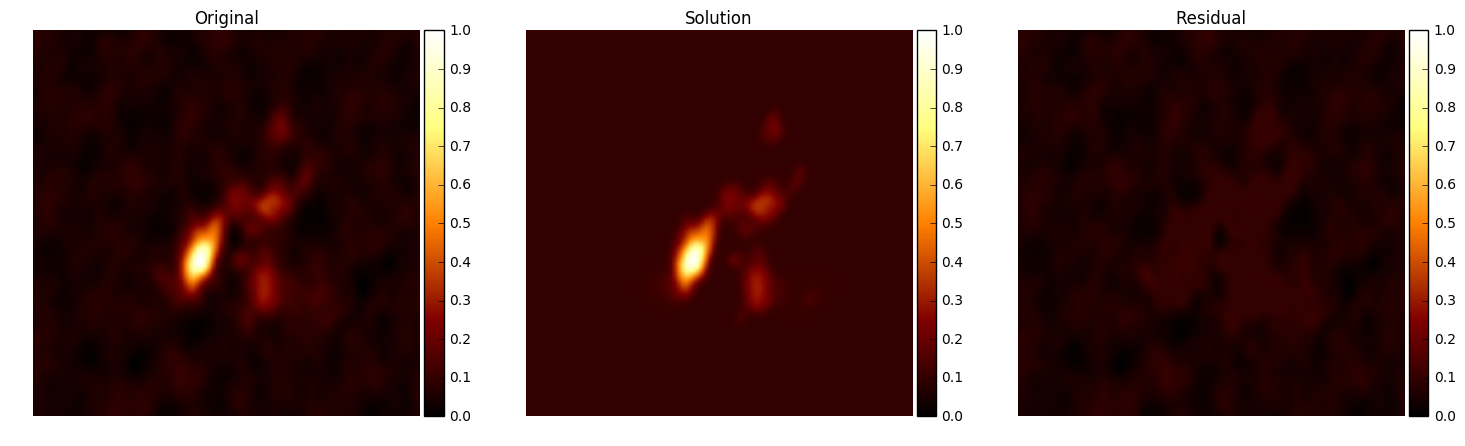

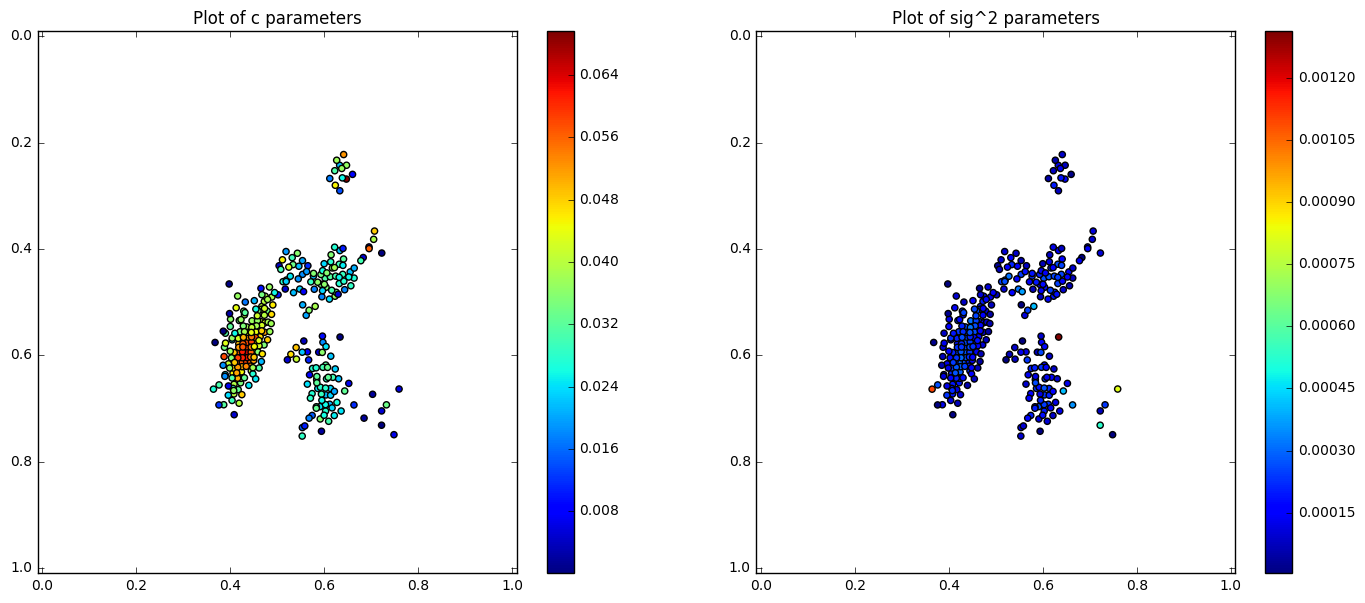

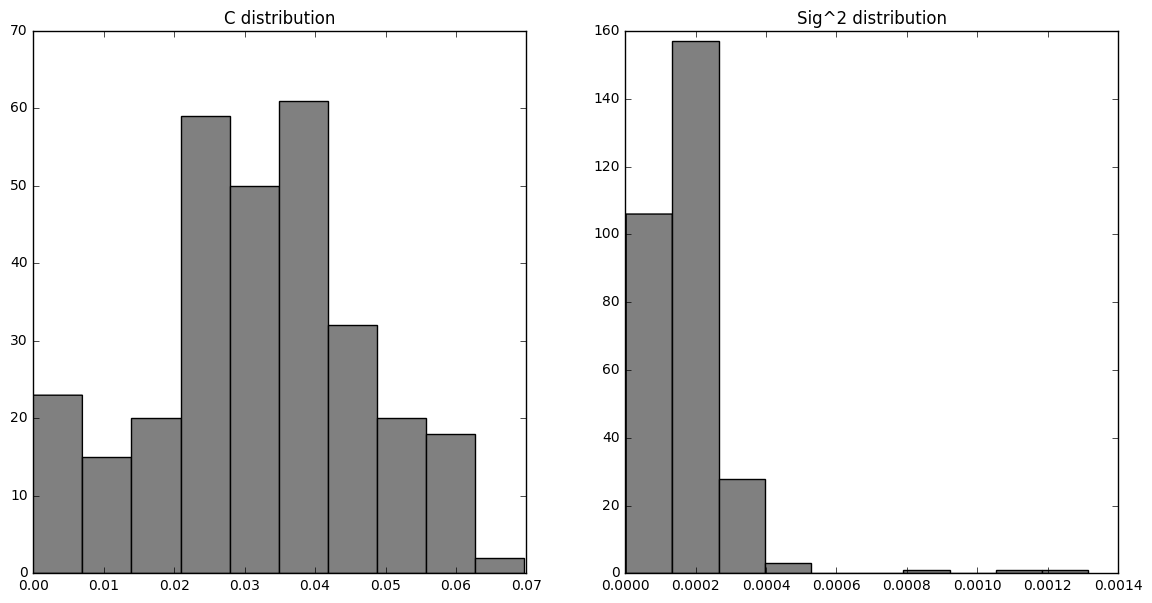

In [23]:
elm_solver(elm022, method='standard', max_nfev=nfev, xtol=1e-9, ftol=1e-9)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120117

Residual stats:
Residual RMS: 0.10104426464
Residual Variance: 1.88677201112e-05
Residual Entropy: 7.09613440777
Total elapsed time: 409.009934902 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.202080548593
Mean min distance between collocation and center points: 0.0118446280635

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0693602915566
Max min distance in the (standarized) parameters space: 0.508279296134


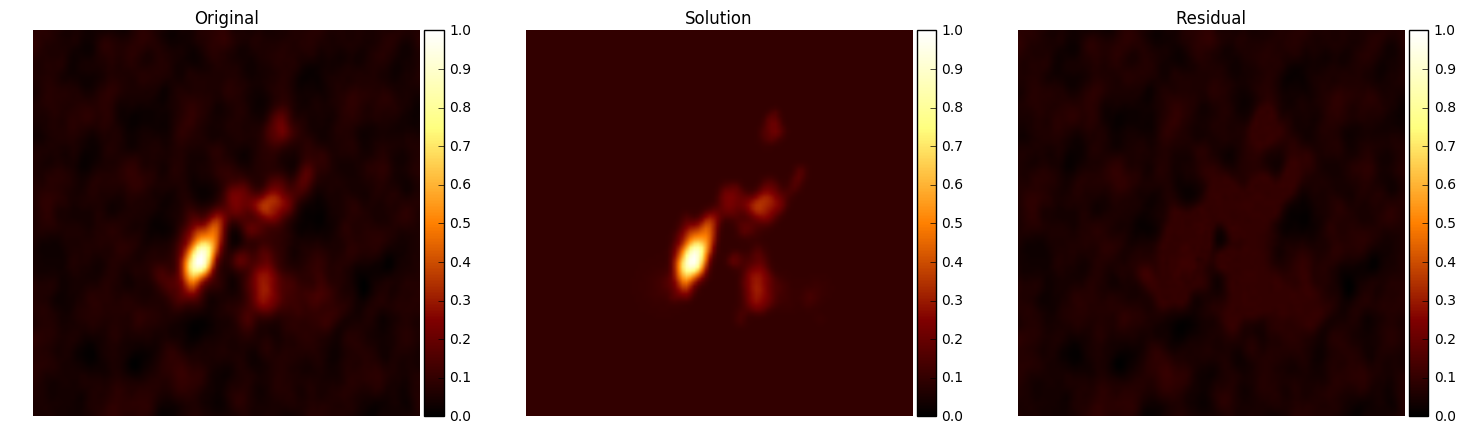

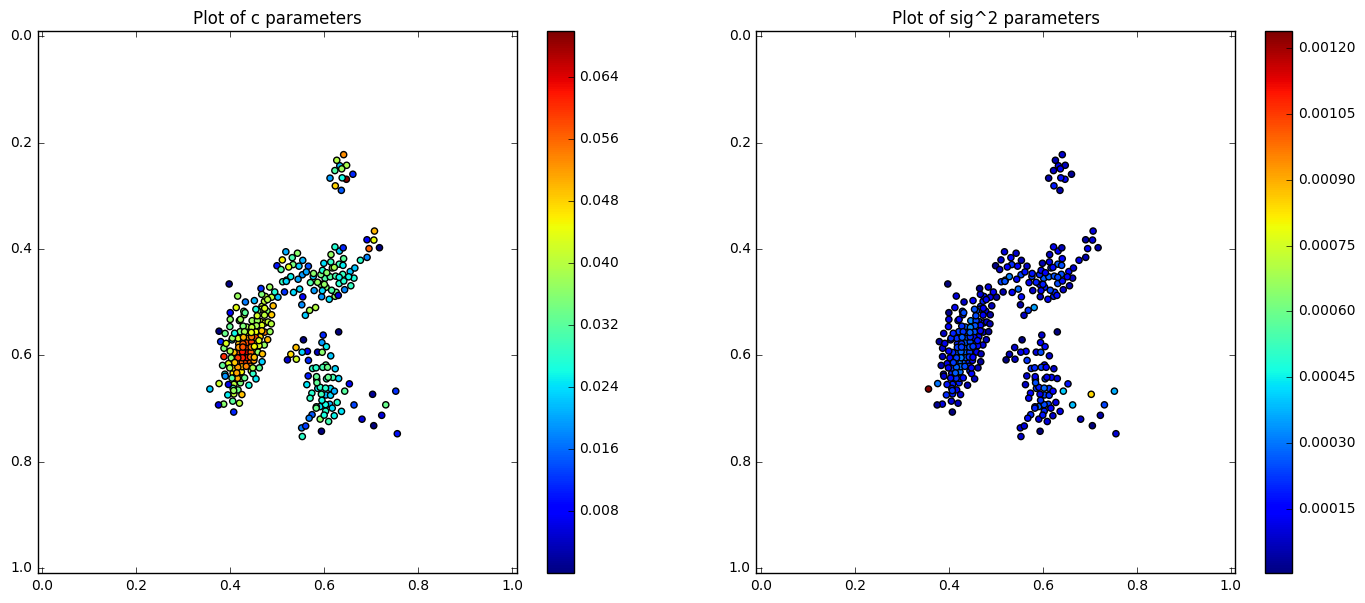

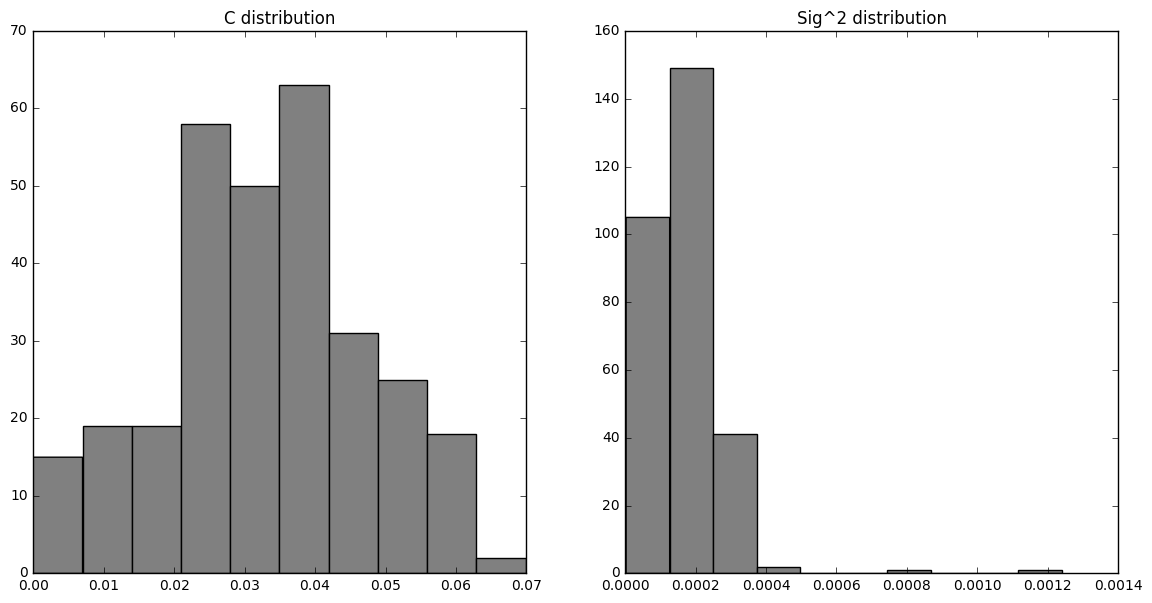

In [24]:
elm_solver(elm023, method='standard', max_nfev=nfev, xtol=1e-10, ftol=1e-10)

***
***

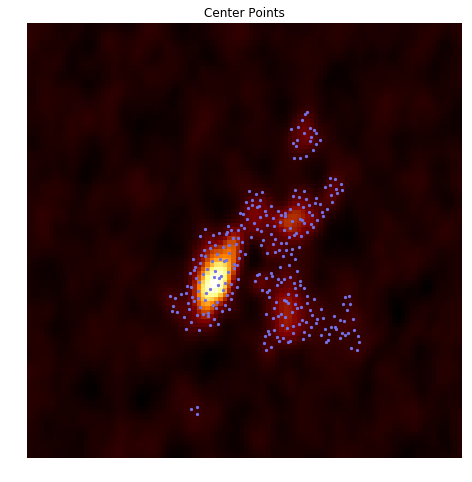

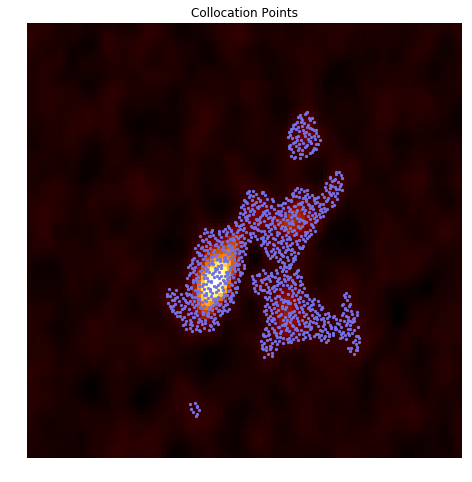

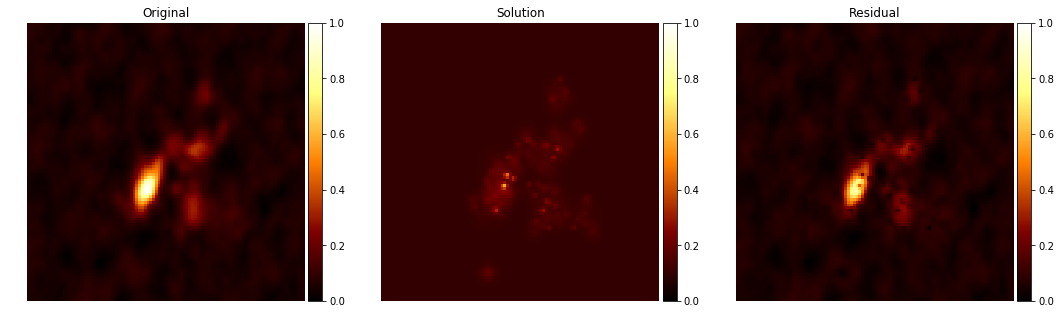

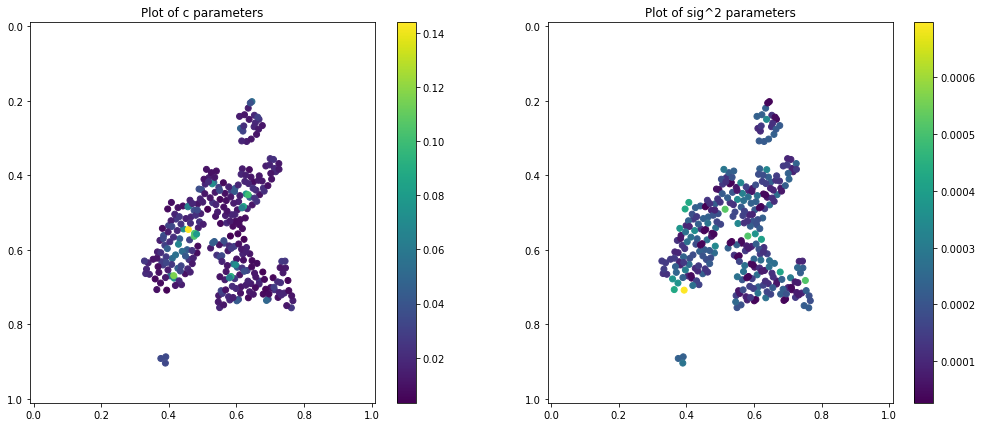

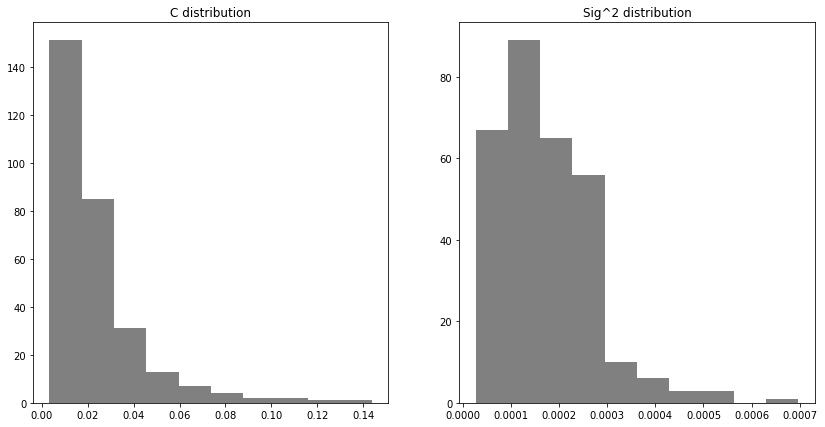

In [19]:
##########################################
# Approach 2
##########################################

collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
center_points = collocation_points[0:Nc]
boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm03 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
               d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

elm04 = copy.deepcopy(elm03)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100000.
nfev: 100892

Residual stats:
Residual RMS: 0.1006714545086686
Residual Variance: 1.7951288545633087e-05
Residual Entropy: 6.929236968444629
Total elapsed time: 720.6110651493073 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.022286757524250005
Mean min distance between collocation and center points: 0.008185657692729246

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06579444214118352
Max min distance in the (standarized) parameters space: 0.3448094594413834


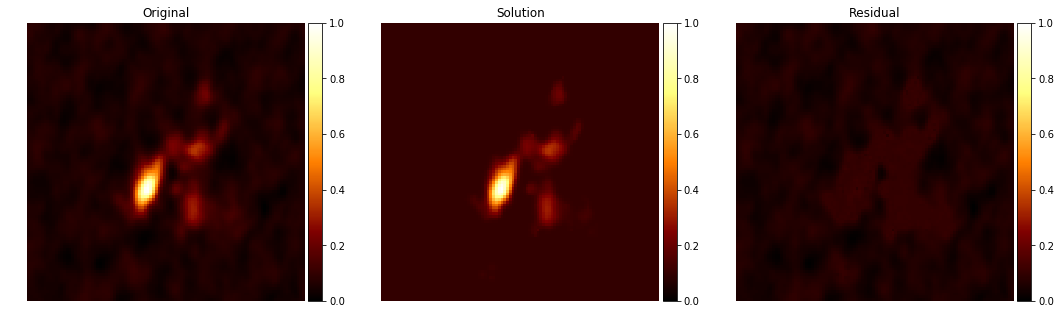

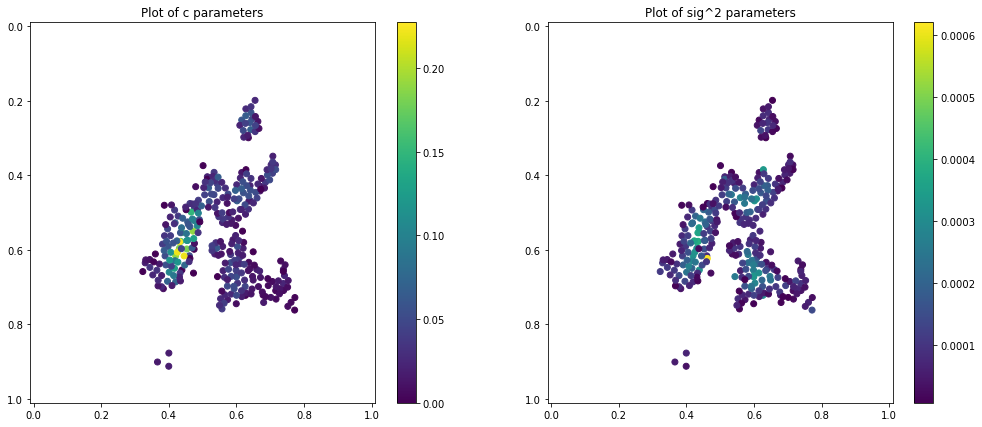

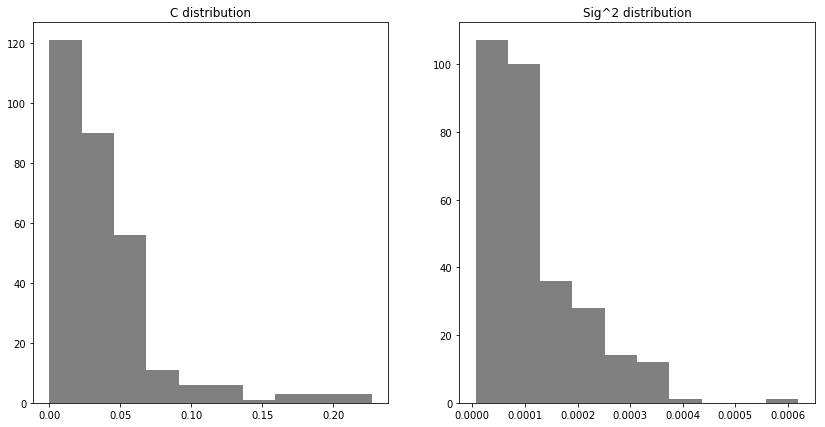

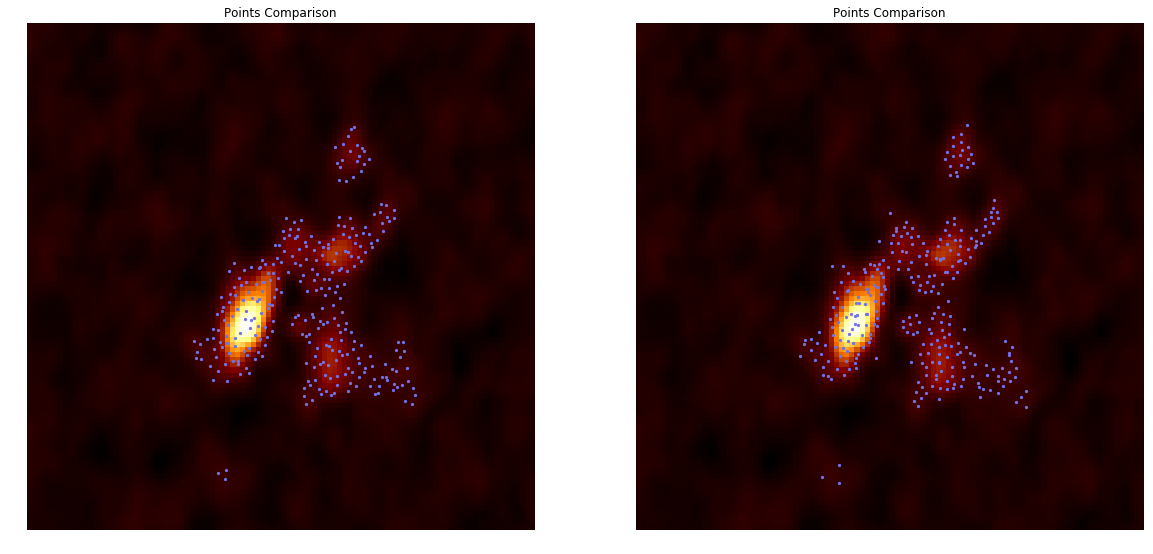

In [20]:
elm_solver(elm03, method='standard', max_nfev=100000)

# visualizing the final/choosen points
fcenter_points = np.vstack((elm03.xc, elm03.yc)).T
points_plot(data, center_points=center_points, collocation_points=fcenter_points, title="Points Comparison")

In [21]:
# gaussian agglomeration
xc, yc, c, sig = elm03.get_params_mapped()
mu = np.vstack([xc, yc]).T

components_dict03 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 230 and 259 with 5.568878691519785e-13 dissimilarity
Merged components 94 and 120 with 6.832930457731852e-13 dissimilarity
Merged components 9 and 297 with 2.7744241099984214e-12 dissimilarity
Merged components 24 and 156 with 5.4072302191343624e-12 dissimilarity
Merged components 181 and 281 with 8.398504114381922e-12 dissimilarity
Merged components 198 and 292 with 8.796892977974572e-12 dissimilarity
Merged components 210 and 293 with 9.44773362644444e-11 dissimilarity
Merged components 212 and 245 with 8.280918676763796e-10 dissimilarity
Merged components 36 and 180 with 1.1112518683020767e-09 dissimilarity
Merged components 128 and 289 with 3.6822210785612186e-09 dissimilarity
Merged components 1 and 107 with 5.4138823178688534e-08 dissimilarity
Merged components 124 and 163 with 3.7278858516648024e-07 dissimilarity
Merged components 36 and 46 with 1.213709967357997e-06 dissimilarity
Merged components 145 and 186 with 2.148229049143754e-06 dissimilarity
Merged com

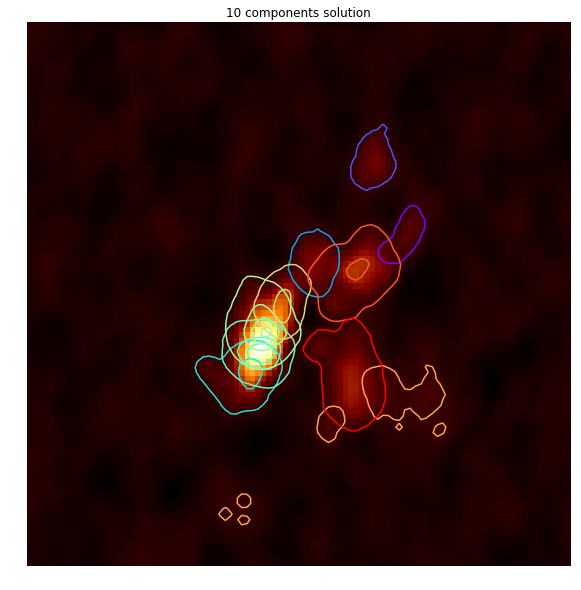

<function graph.components_plot>

In [22]:
interact(components_plot, elm=fixed(elm03), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

***


##########################################################################################
Results after 1 iterations
##########################################################################################

success: False

status: 5

message: Number of calls to function has reached maxfev = 10000.

nfev: 10814

##########################################################################################
Results after 2 iterations
##########################################################################################

success: True

status: 2

message: The relative error between two consecutive iterates is at most 0.000000

nfev: 1211

 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 1211

Residual stats:
Resid

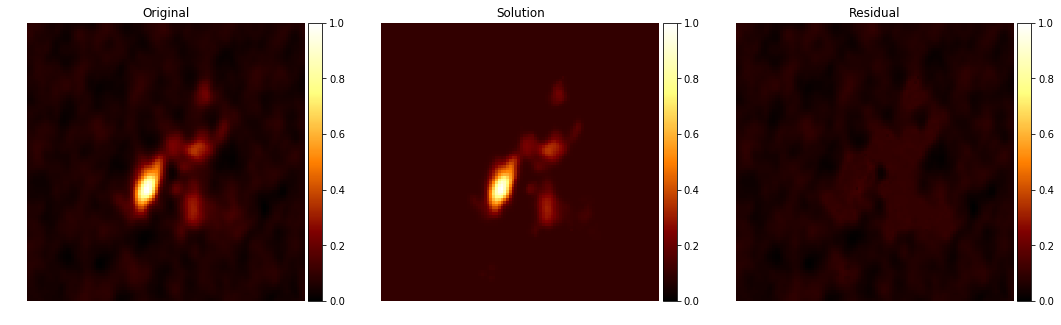

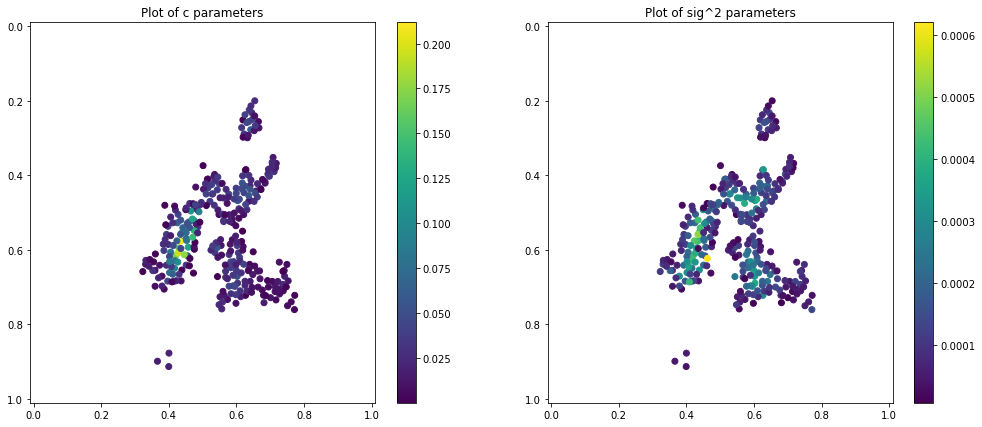

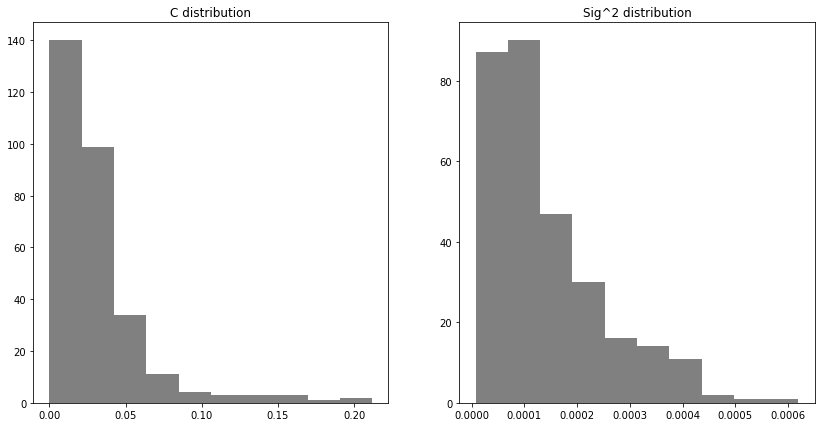

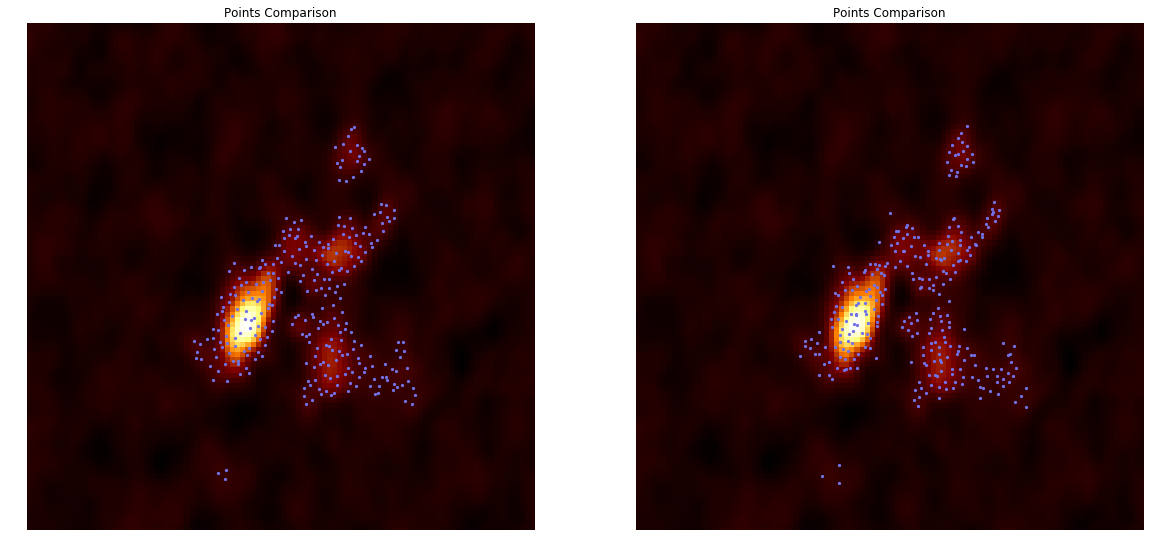

In [23]:
elm_solver(elm04, method='iterative', max_nfev=10000, n_iter=10)

# visualizing the final/choosen points
fcenter_points = np.vstack((elm04.xc, elm04.yc)).T
points_plot(data, center_points=center_points, collocation_points=fcenter_points, title="Points Comparison")

In [24]:
# gaussian agglomeration
xc, yc, c, sig = elm04.get_params_mapped()
mu = np.vstack([xc, yc]).T

components_dict04 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 94 and 120 with 3.6902537472075533e-09 dissimilarity
Merged components 38 and 155 with 1.8581480021317986e-08 dissimilarity
Merged components 118 and 250 with 1.0847499028711885e-07 dissimilarity
Merged components 29 and 199 with 2.5866041616089247e-07 dissimilarity
Merged components 7 and 223 with 9.175044962710907e-07 dissimilarity
Merged components 24 and 246 with 1.3030973817218516e-05 dissimilarity
Merged components 33 and 178 with 2.1428848203412698e-05 dissimilarity
Merged components 8 and 123 with 2.7617397582335723e-05 dissimilarity
Merged components 123 and 207 with 3.874368416247791e-05 dissimilarity
Merged components 145 and 188 with 5.6155447690671976e-05 dissimilarity
Merged components 11 and 209 with 0.00010443109255031668 dissimilarity
Merged components 70 and 242 with 0.00010446064989068707 dissimilarity
Merged components 97 and 172 with 0.0001556439166223722 dissimilarity
Merged components 1 and 101 with 0.00031565729165424633 dissimilarity
Merged co

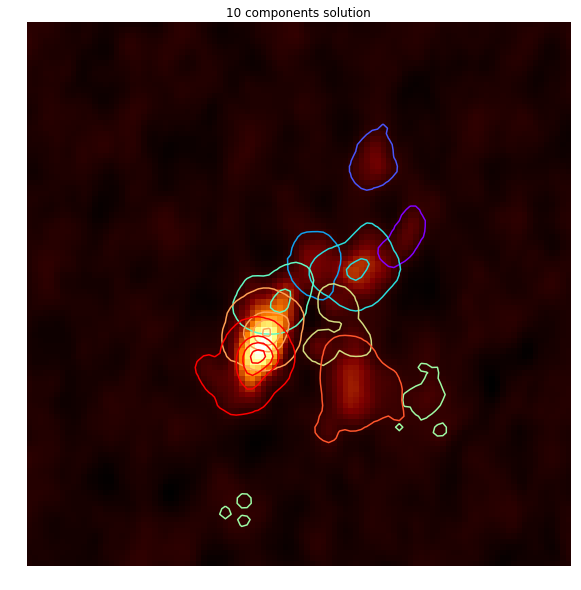

<function graph.components_plot>

In [25]:
interact(components_plot, elm=fixed(elm04), data=fixed(data), components_dict=fixed(components_dict04), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

***
***

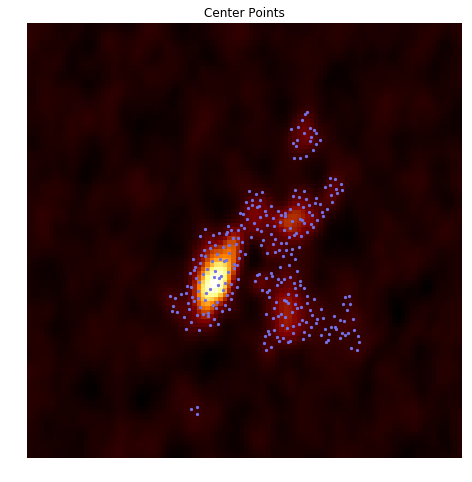

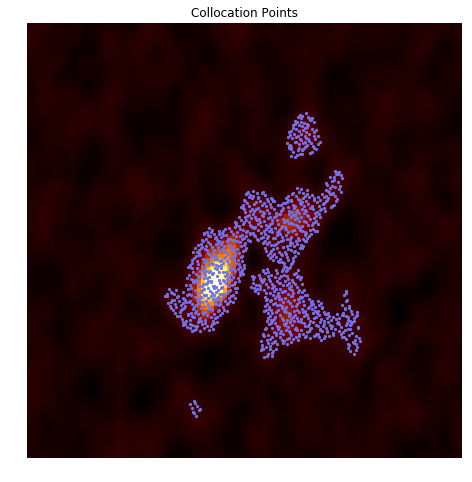

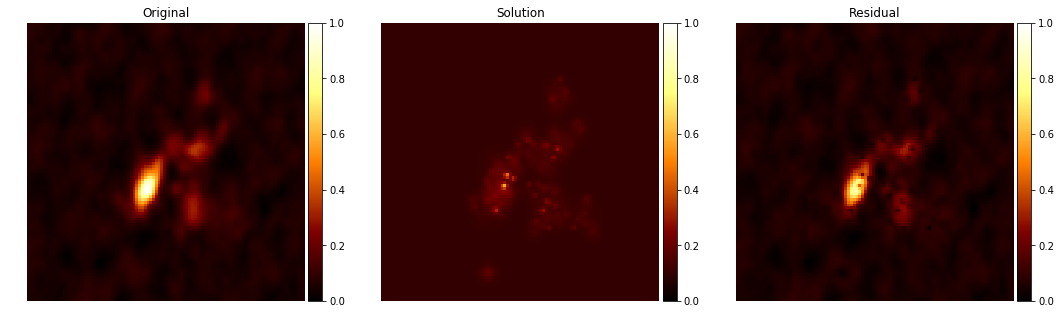

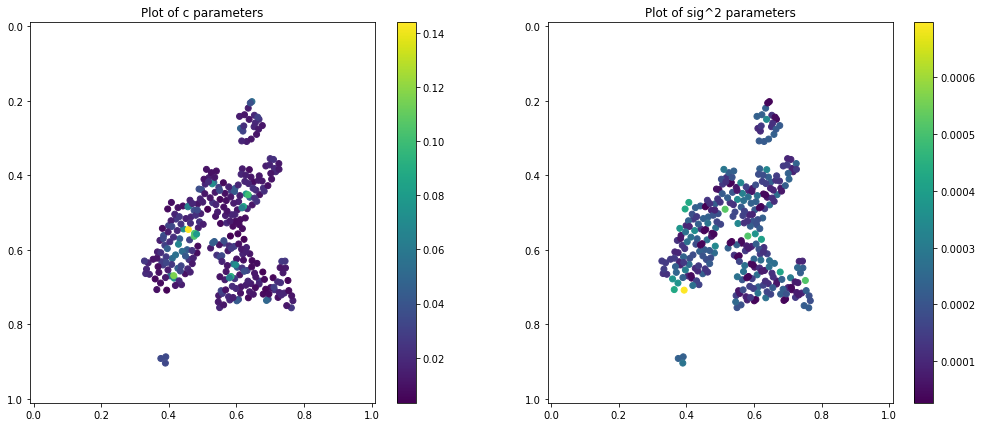

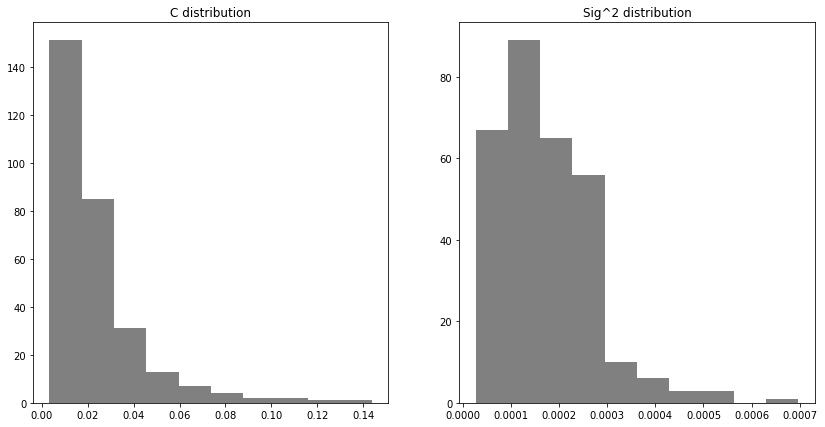

In [26]:
##########################################
# Approach 3
##########################################

points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
center_points = points[0:Nc]
collocation_points = points[Nc:Nc+Ne]
boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm05 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
               d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

elm06 = copy.deepcopy(elm05)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100000.
nfev: 100897

Residual stats:
Residual RMS: 0.10087137033505908
Residual Variance: 1.7853595295111176e-05
Residual Entropy: 6.778015221497524
Total elapsed time: 647.4503047466278 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.022084723014854084
Mean min distance between collocation and center points: 0.008274208405912907

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06793663217952217
Max min distance in the (standarized) parameters space: 0.2232728073577159


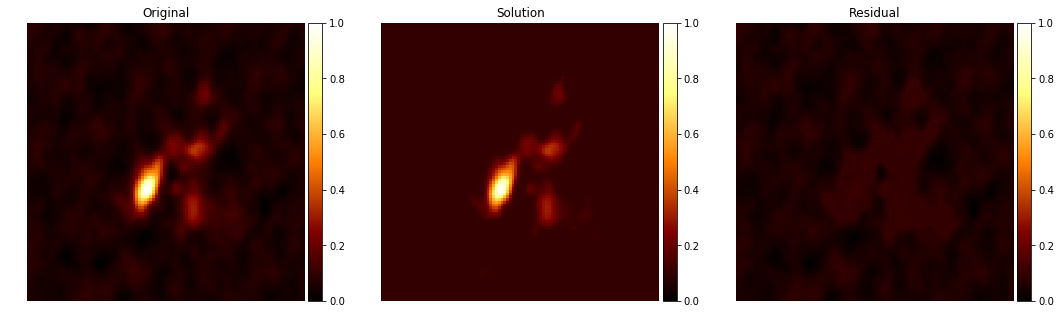

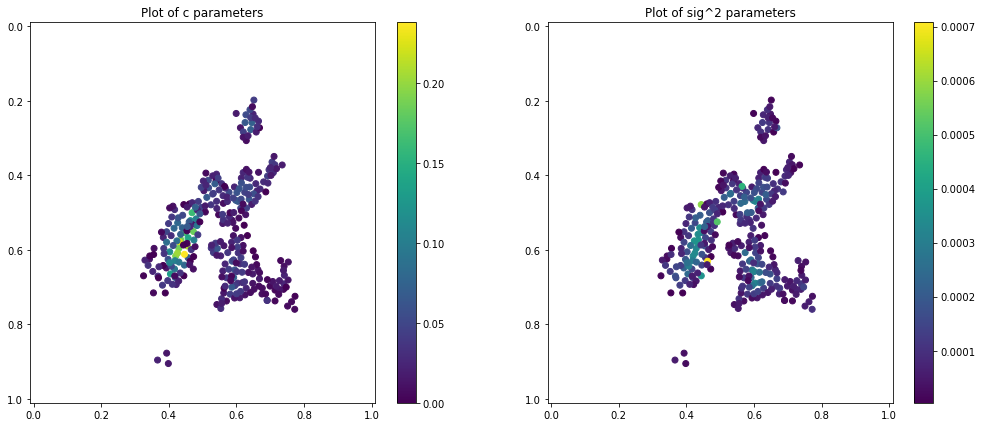

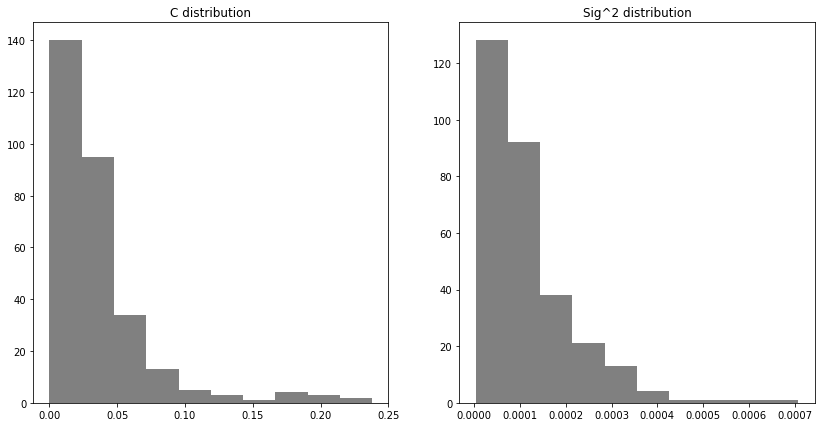

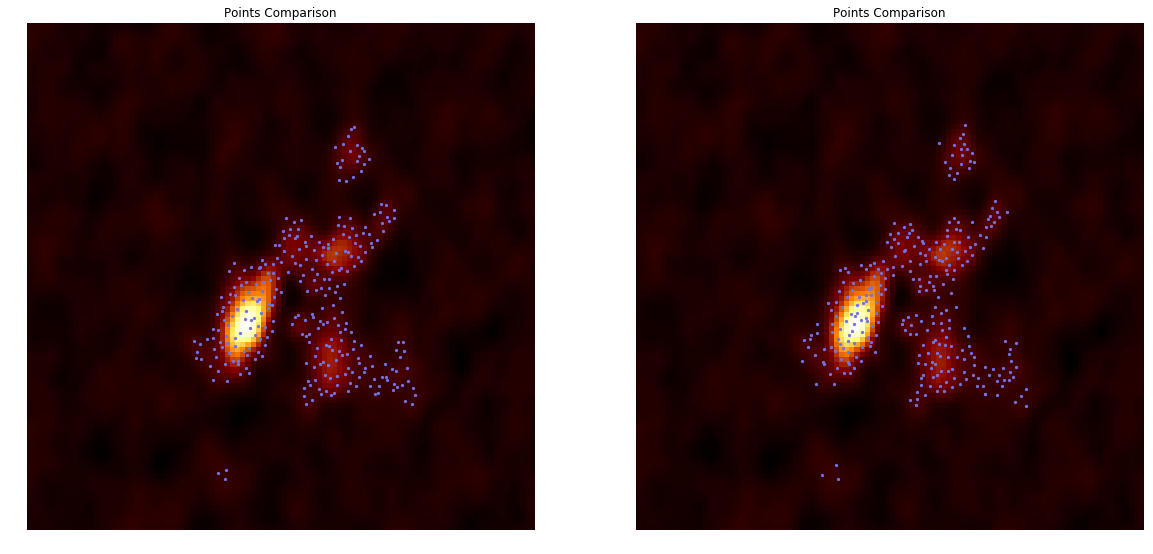

In [27]:
elm_solver(elm05, method='standard', max_nfev=100000)

# visualizing the final/choosen points
fcenter_points = np.vstack((elm05.xc, elm05.yc)).T
points_plot(data, center_points=center_points, collocation_points=fcenter_points, title="Points Comparison")

In [28]:
# gaussian agglomeration
xc, yc, c, sig = elm05.get_params_mapped()
mu = np.vstack([xc, yc]).T

components_dict05 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 21 and 201 with 9.897237696538658e-15 dissimilarity
Merged components 9 and 119 with 1.6748672311398645e-13 dissimilarity
Merged components 155 and 240 with 1.0791680756014942e-12 dissimilarity
Merged components 246 and 281 with 1.6318613127452863e-12 dissimilarity
Merged components 269 and 293 with 6.624123020062982e-12 dissimilarity
Merged components 52 and 294 with 1.596747877107497e-11 dissimilarity
Merged components 115 and 240 with 2.402572585324947e-11 dissimilarity
Merged components 54 and 213 with 3.938170286200741e-11 dissimilarity
Merged components 73 and 252 with 2.0421685273161145e-09 dissimilarity
Merged components 48 and 269 with 7.065615093004851e-09 dissimilarity
Merged components 93 and 227 with 2.22252478198111e-07 dissimilarity
Merged components 129 and 204 with 1.996614848498446e-05 dissimilarity
Merged components 200 and 225 with 2.6854581255395145e-05 dissimilarity
Merged components 142 and 222 with 3.486996964602307e-05 dissimilarity
Merged com

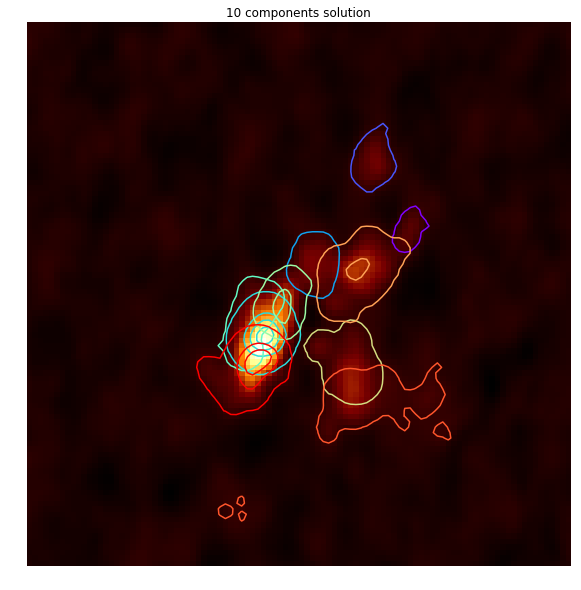

<function graph.components_plot>

In [29]:
interact(components_plot, elm=fixed(elm05), data=fixed(data), components_dict=fixed(components_dict05), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

***


##########################################################################################
Results after 1 iterations
##########################################################################################

success: False

status: 5

message: Number of calls to function has reached maxfev = 10000.

nfev: 10814

##########################################################################################
Results after 2 iterations
##########################################################################################

success: False

status: 5

message: Number of calls to function has reached maxfev = 10000.

nfev: 10818

##########################################################################################
Results after 3 iterations
##########################################################################################

success: True

status: 2

message: The relative error between two consecutive iterates is at most 0.000000

nfev: 1211

 
###################################

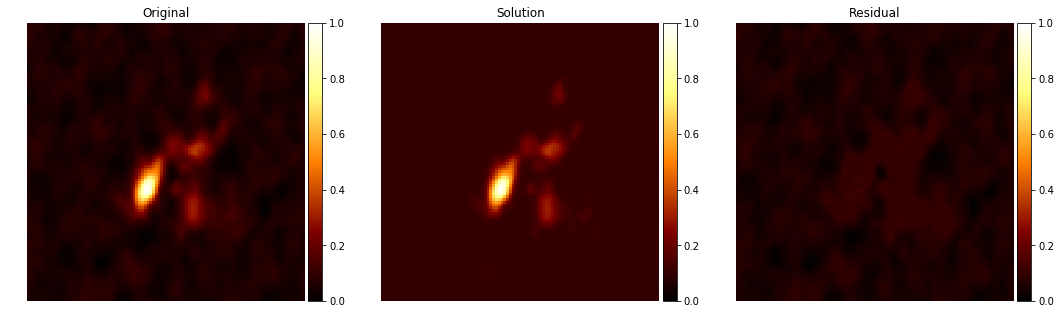

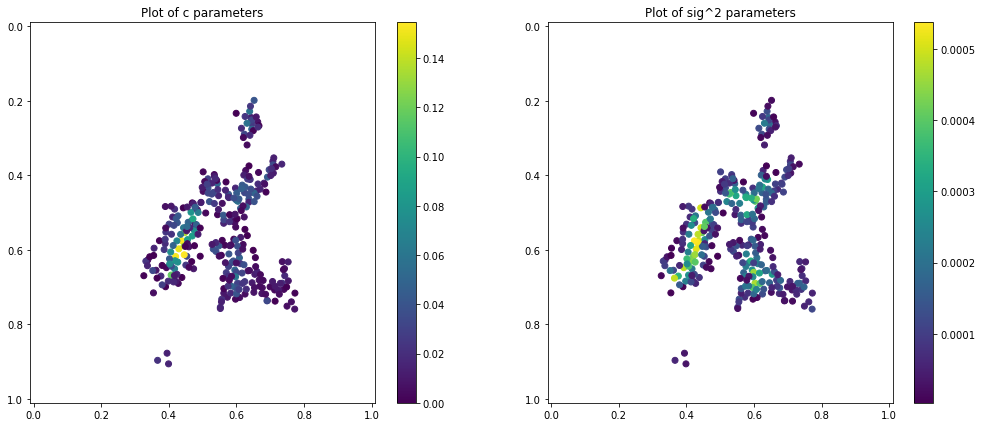

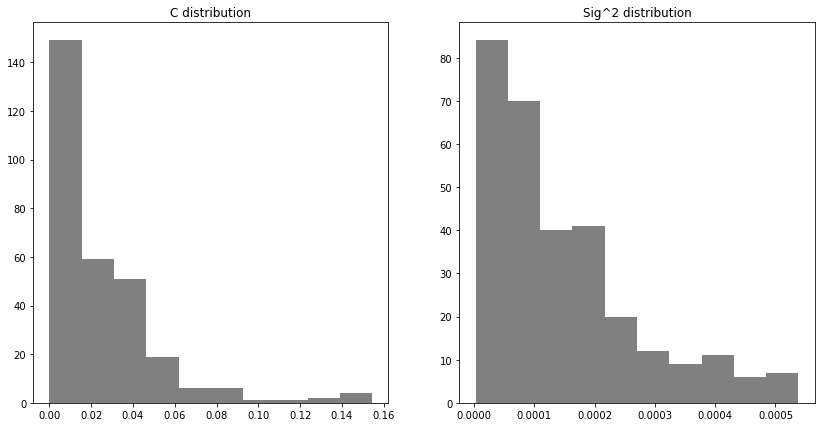

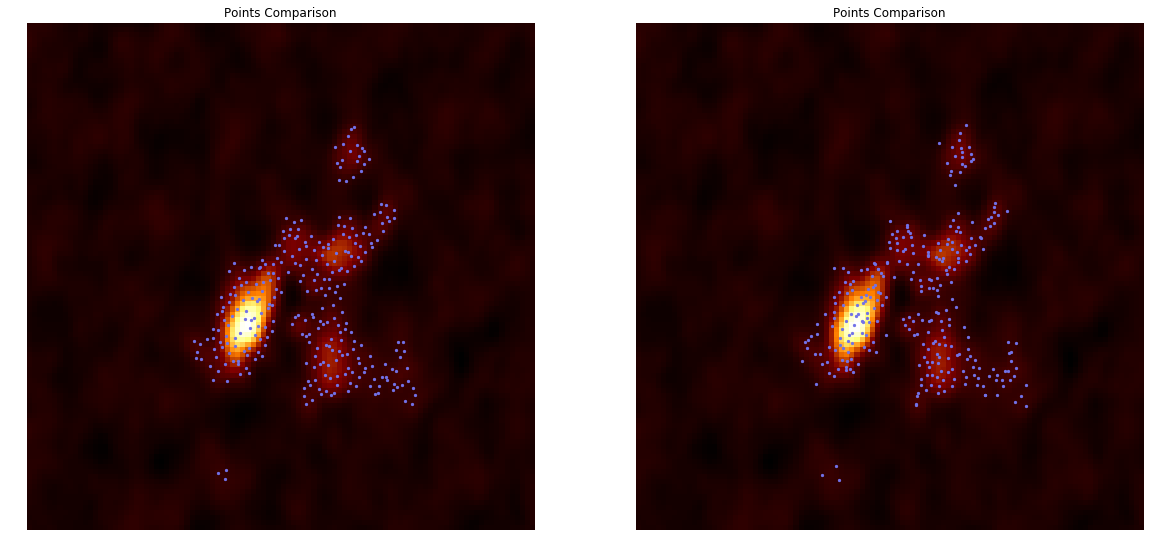

In [30]:
elm_solver(elm06, method='iterative', max_nfev=10000, n_iter=10)

# visualizing the final/choosen points
fcenter_points = np.vstack((elm06.xc, elm06.yc)).T
points_plot(data, center_points=center_points, collocation_points=fcenter_points, title="Points Comparison")

In [31]:
# gaussian agglomeration
xc, yc, c, sig = elm06.get_params_mapped()
mu = np.vstack([xc, yc]).T

components_dict06 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 156 and 201 with 3.5290667311342258e-12 dissimilarity
Merged components 118 and 245 with 1.9338429774196086e-08 dissimilarity
Merged components 9 and 101 with 3.6139001480250954e-07 dissimilarity
Merged components 195 and 270 with 8.778817823826792e-07 dissimilarity
Merged components 117 and 128 with 2.6217119047933224e-06 dissimilarity
Merged components 60 and 217 with 4.449779432334766e-06 dissimilarity
Merged components 151 and 234 with 7.266509106348646e-06 dissimilarity
Merged components 94 and 170 with 6.0086835999062504e-05 dissimilarity
Merged components 9 and 276 with 6.053466944266894e-05 dissimilarity
Merged components 236 and 270 with 7.203910795380852e-05 dissimilarity
Merged components 199 and 226 with 0.0001188421175797958 dissimilarity
Merged components 42 and 241 with 0.0001399074000221429 dissimilarity
Merged components 163 and 205 with 0.00015872694196340434 dissimilarity
Merged components 47 and 260 with 0.00017209706649717882 dissimilarity
Merged 

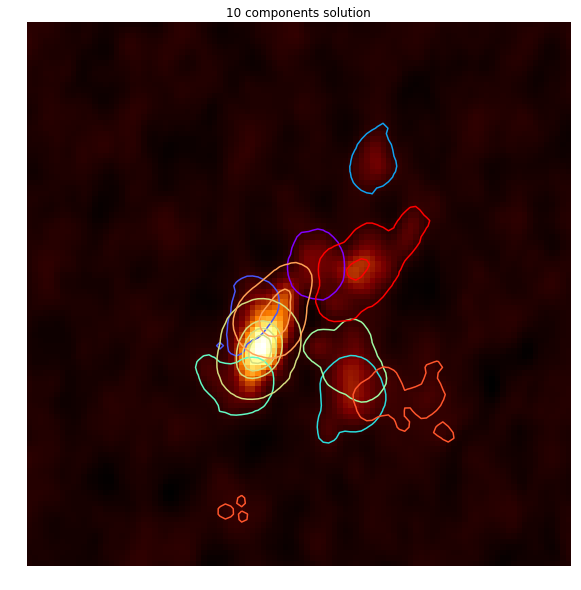

<function graph.components_plot>

In [32]:
interact(components_plot, elm=fixed(elm06), data=fixed(data), components_dict=fixed(components_dict06), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

***
***
***

# Agglomeration of Gaussians Step 

## Gaussian reduction through `KL-divergence`
### _A Kullback-Leibler Approach to Gaussian Mixture Reduction_

In [16]:
@numba.jit('float64[:,:] (float64[:], float64[:])')
def _outer(x, y):
    m = x.shape[0]
    n = y.shape[0]
    res = np.empty((m, n), dtype=np.float64)
    for i in range(m):
        for j in range(n):
            res[i, j] = x[i]*y[j]
    return res

@numba.jit('float64 (float64[:,:])')
def _det2D(X):
    return X[0,0]*X[1,1] - X[0,1]*X[1,0]

In [16]:
@numba.jit('Tuple((float64, float64[:], float64[:,:])) (float64, float64[:], float64[:,:], float64, float64[:], float64[:,:])', nopython=True)
def merge(c1, mu1, sig1, c2, mu2, sig2):
    c_m = c1+c2
    mu_m = (c1/c_m)*mu1 + (c2/c_m)*mu2
    sig_m = (c1/c_m)*sig1 + (c2/c_m)*sig2 + (c1/c_m)*(c2/c_m)*_outer(mu1-mu2, mu1-mu2)
    return (c_m, mu_m, sig_m) 

@numba.jit('float64 (float64, float64[:], float64[:,:], float64, float64[:], float64[:,:])', nopython=True)
def KL_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    # merged moment preserving gaussian
    c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
    # KL divergence upper bound as proposed in: A Kullback-Leibler Approach to Gaussian Mixture Reduction
    return 0.5*((c1+c2)*np.log(_det2D(sig_m)) - c1*np.log(_det2D(sig1)) - c2*np.log(_det2D(sig2)))

In [17]:
# def merge(c1, mu1, sig1, c2, mu2, sig2):
#     c_m = c1+c2
#     mu_m = (c1/c_m)*mu1 + (c2/c_m)*mu2
#     sig_m = (c1/c_m)*sig1 + (c2/c_m)*sig2 + (c1/c_m)*(c2/c_m)*np.outer(mu1-mu2, mu1-mu2)
#     return (c_m, mu_m, sig_m)

# def KL_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
#     # merged moment preserving gaussian
#     c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
#     # KL divergence upper bound as proposed in: A Kullback-Leibler Approach to Gaussian Mixture Reduction
#     return 0.5*((c1+c2)*np.log(np.linalg.det(sig_m)) - c1*np.log(np.linalg.det(sig1)) - c2*np.log(np.linalg.det(sig2)))

In [18]:
def gaussian_reduction(c, mu, sig, n_comp, metric=KL_dissimilarity):
    c = c.tolist(); mu = map(np.array, mu.tolist()); sig = [(s**2)*np.identity(2) for s in sig]
    # indexes of the actual gaussian components
    components = [[i] for i in range(len(c))]
    components_dict = {len(components) : copy.deepcopy(components)}
    # main loop
    while len(components)>n_comp:
        m = len(c)
        diss_min = np.inf
        i_min = -1; j_min = -1
        for i in range(m):
            for j in range(i+1,m):
                diss = metric(c[i], mu[i], sig[i], c[j], mu[j], sig[j])
                if diss < diss_min: i_min = i; j_min = j; diss_min = diss
        # compute the moment preserving  merged gaussian
        c_m, mu_m, sig_m = merge(c[i_min], mu[i_min], sig[i_min], c[j_min], mu[j_min], sig[j_min])
        # updating structures
        print('Merged components {0} and {1} with {2} dissimilarity'.format(i_min, j_min, diss_min))
        del c[max(i_min, j_min)]; del c[min(i_min, j_min)]; c.append(c_m)
        del mu[max(i_min, j_min)]; del mu[min(i_min, j_min)]; mu.append(mu_m)
        del sig[max(i_min, j_min)]; del sig[min(i_min, j_min)]; sig.append(sig_m)
        new_component = components.pop(max(i_min,j_min)) + components.pop(min(i_min,j_min))
        new_component.sort()
        components.append(new_component)
        components_dict[m-1] = copy.deepcopy(components)
    return components_dict

In [20]:
# extracting parameters
if elm01.square_c: c = elm01.c**2
else: c = elm01.c
    
mu = np.vstack([elm01.xc, elm01.yc]).T
sig = elm01.sig

In [21]:
components_dict01 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 215 and 265 with 3.15220072267e-12 dissimilarity
Merged components 72 and 193 with 0.000389596015503 dissimilarity
Merged components 123 and 194 with 0.000392498613768 dissimilarity
Merged components 253 and 264 with 0.000547201560059 dissimilarity
Merged components 161 and 163 with 0.00144317347341 dissimilarity
Merged components 145 and 263 with 0.00243492473472 dissimilarity
Merged components 185 and 275 with 0.00245437792746 dissimilarity
Merged components 156 and 197 with 0.00262623286292 dissimilarity
Merged components 10 and 133 with 0.00266305106506 dissimilarity
Merged components 165 and 211 with 0.00276397341846 dissimilarity
Merged components 87 and 139 with 0.00283917275237 dissimilarity
Merged components 107 and 218 with 0.00296733269542 dissimilarity
Merged components 102 and 173 with 0.00313338733919 dissimilarity
Merged components 157 and 269 with 0.00327032353458 dissimilarity
Merged components 74 and 127 with 0.00341085079887 dissimilarity
Merged com

In [27]:
def components_plot(elm, data, components_dict, n_comp, dims, resolution=1, n_levels=5):
    xc = elm.xc; yc = elm.yc; c = elm.c; sig = elm.sig
    _xe = np.linspace(0., 1., resolution*dims[0])[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1])[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False, indexing='ij')
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if elm.square_c: c = c**2
    if elm.compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)    
    
    plt.figure(figsize=(10,10))
    plt.title('{0} components solution'.format(n_comp))
    plt.axis('off')
    ax = plt.subplot(1,1,1)
    ax.imshow(data, cmap=plt.cm.afmhot)
    color = plt.cm.rainbow(np.linspace(0.,1.,n_comp))
    levels = np.linspace(1.05*base_level, 0.95, n_levels)
    
    
    for i,indexes in enumerate(components_dict[n_comp]):
        _phi_m = phi_m.T[indexes].T
        _c = c[indexes]
        _u = np.dot(_phi_m, _c) + elm.base_level
        _u = _u.reshape(len_xe, len_ye)
        
        ax.contour(_u, levels=levels, colors=[color[i]])
        #plt.subplot(n_comp,1, i+1)
        #ax = plt.gca()
        #im = ax.imshow(_u, vmin=0., vmax=1.)
        #plt.axis('off')
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #plt.colorbar(im, cax=cax)
    plt.show()
    
def components_plot2(elm, components_dict, n_comp, dims, resolution=2):
    xc = elm.xc; yc = elm.yc; c = elm.c; sig = elm.sig
    _xe = np.linspace(0., 1., resolution*dims[0])[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1])[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False, indexing='ij')
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if elm.square_c: c = c**2
    if elm.compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)    
    
    plt.figure(figsize=(12,12))
    plt.title('{0} components solution'.format(n_comp))
    j = 1
    
    for i,indexes in enumerate(components_dict[n_comp]):
        _phi_m = phi_m.T[indexes].T
        _c = c[indexes]
        _u = np.dot(_phi_m, _c) + elm.base_level
        _u = _u.reshape(len_xe, len_ye)
        
        __u = _u[_u > base_level]
        
        plt.subplot(n_comp,1, j)
        j+=1
        
        ax = plt.gca()
        __u = np.log10(_u)
        im = ax.imshow(_u, vmin=0., vmax=1.)
        #im = ax.imshow((__u + __u.min())/(__u.max()-__u.min()), vmin=0., vmax=1.)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        #plt.subplot(2*n_comp,1,j)
        #plt.hist(_u.ravel(), bins=400, log=True)
        #j+=1
    plt.show()

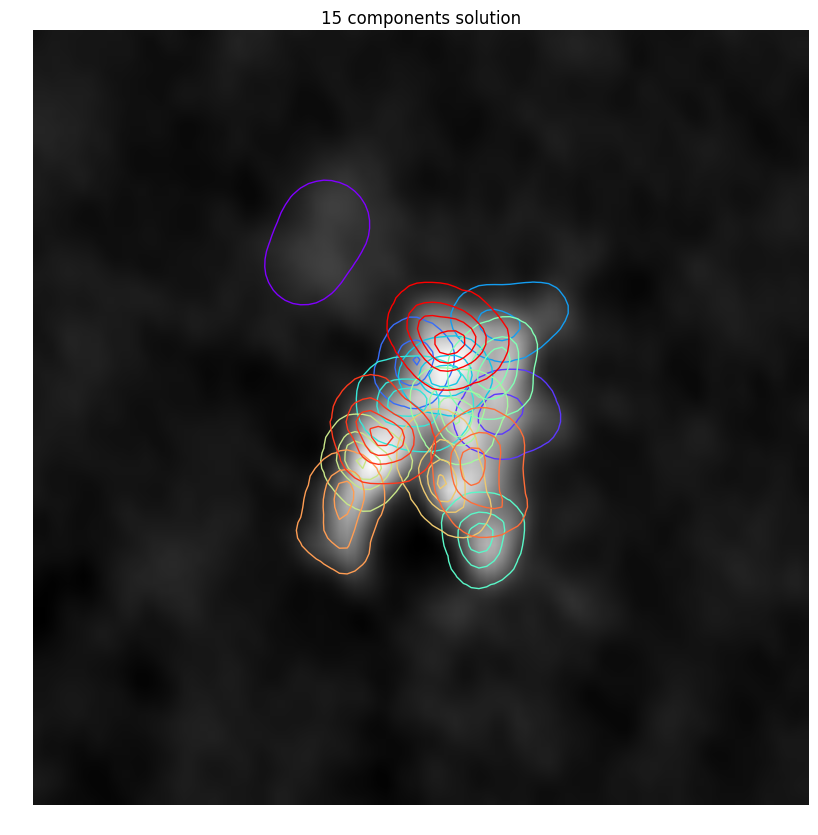

In [23]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

## Gaussian reduction through `ISD` (_Integrated Square Difference_)
### _Cost-Function-Based Gaussian Mixture Reduction for Target Tracking_

In [25]:
def ISD_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    # merged moment preserving gaussian
    c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
    # ISD analytical computation between merged component and the pair of gaussians
    Jhr = c1*c_m * np.exp( -0.5 * np.dot((mu1-mu_m), np.dot(np.linalg.inv(sig1+sig_m), mu1-mu_m)) ) + c2*c_m * np.exp( -0.5 * np.dot((mu2-mu_m), np.dot(np.linalg.inv(sig2+sig_m), mu2-mu_m)) )
    Jrr = c_m**2
    Jhh = c1**2 + c2**2 + 2*c1*c2* np.exp( -0.5 * np.dot((mu1-mu2), np.dot(np.linalg.inv(sig1+sig2), mu1-mu2)) )
    return Jhh - 2*Jhr + Jrr

In [26]:
comp2 = gaussian_reduction(c, mu, sig, n_comp=5, metric=ISD_dissimilarity)

Merged components 17 and 119 with -0.000200013884597 dissimilarity
Merged components 306 and 398 with -0.000235953983332 dissimilarity
Merged components 121 and 397 with -0.000342140038192 dissimilarity
Merged components 65 and 396 with -0.00032146949332 dissimilarity
Merged components 365 and 395 with -0.000359771913569 dissimilarity
Merged components 263 and 394 with -0.000364646936305 dissimilarity
Merged components 38 and 393 with -0.000309154480762 dissimilarity
Merged components 104 and 392 with -0.000328369914074 dissimilarity
Merged components 22 and 391 with -0.00029842775168 dissimilarity
Merged components 181 and 390 with -0.000290889917902 dissimilarity
Merged components 42 and 389 with -0.000235214072781 dissimilarity
Merged components 342 and 388 with -0.000305791257825 dissimilarity
Merged components 117 and 387 with -0.000297282681962 dissimilarity
Merged components 227 and 386 with -0.000323941937473 dissimilarity
Merged components 34 and 385 with -0.000298842733164 di

KeyboardInterrupt: 

***
***
***
***
***

# Test with Trust Region Reflective algorithm

In [14]:
elm0x = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=base_level, square_c=False, compact_supp=True, pix_freedom=1.)

###############################################
# Test with Trust Region Reflective algorithm
###############################################

t0 = time.time()

xc_lower_bound = elm0x.xc - elm0x.deltax
xc_upper_bound = elm0x.xc + elm0x.deltax

yc_lower_bound = elm0x.yc - elm0x.deltay
yc_upper_bound = elm0x.yc + elm0x.deltay

c_lower_bound = np.zeros(Nc)
c_upper_bound = +np.inf*np.ones(Nc)

sig_lower_bound = -np.inf*np.ones(Nc)
sig_upper_bound = +np.inf*np.ones(Nc)

lower = np.concatenate([xc_lower_bound, yc_lower_bound, c_lower_bound, sig_lower_bound])
upper = np.concatenate([xc_upper_bound, yc_upper_bound, c_upper_bound, sig_upper_bound])


sol = sp.optimize.least_squares(elm0x._F, np.concatenate([elm0x.xc, elm0x.yc, elm0x.c, elm0x.sig]),
                                bounds=(lower,upper), method='trf', tr_solver='lsmr', verbose=2, max_nfev=1000)

print('Elapsed time: {0} [s]'.format(time.time()-t0))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7063e+02                                    5.96e+02    
       1              2         5.7761e+01      1.13e+02       6.20e-02       7.05e+02    
       2              3         4.8379e+01      9.38e+00       1.58e-01       6.96e+02    
       3              4         4.0573e+01      7.81e+00       8.04e-03       4.24e+02    
       4              5         3.1178e+01      9.40e+00       2.37e-02       1.17e+03    
       5              7         2.2076e+01      9.10e+00       7.29e-02       1.59e+02    
       6              9         1.4452e+01      7.62e+00       3.51e-02       1.22e+02    
       7             10         8.9167e+00      5.53e+00       6.84e-02       3.40e+02    
       8             12         6.3153e+00      2.60e+00       1.74e-02       4.34e+01    
       9             13         4.5855e+00      1.73e+00       3.38e-02       5.74e+01    

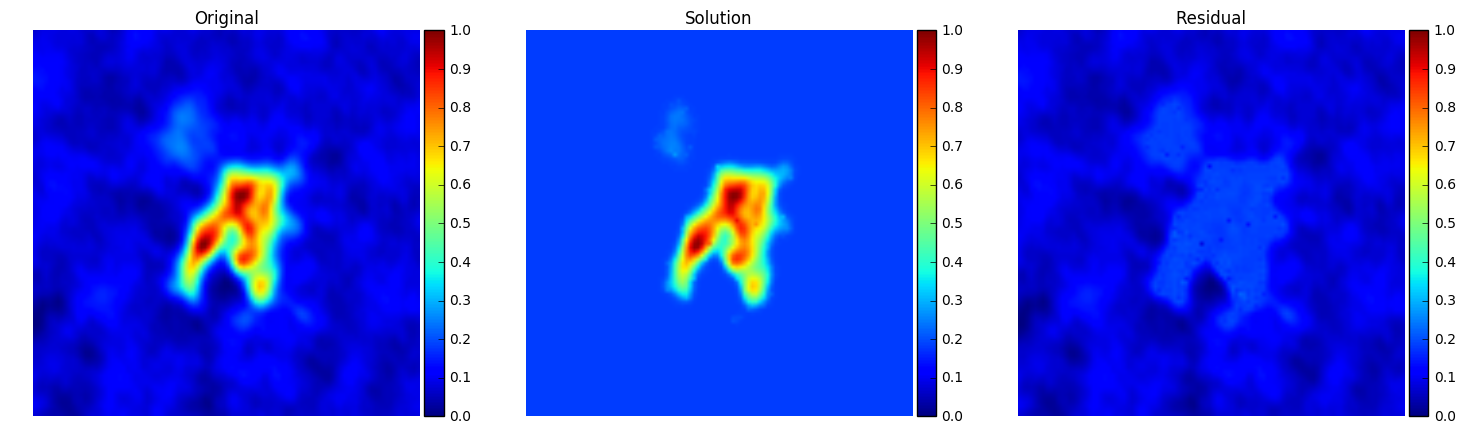

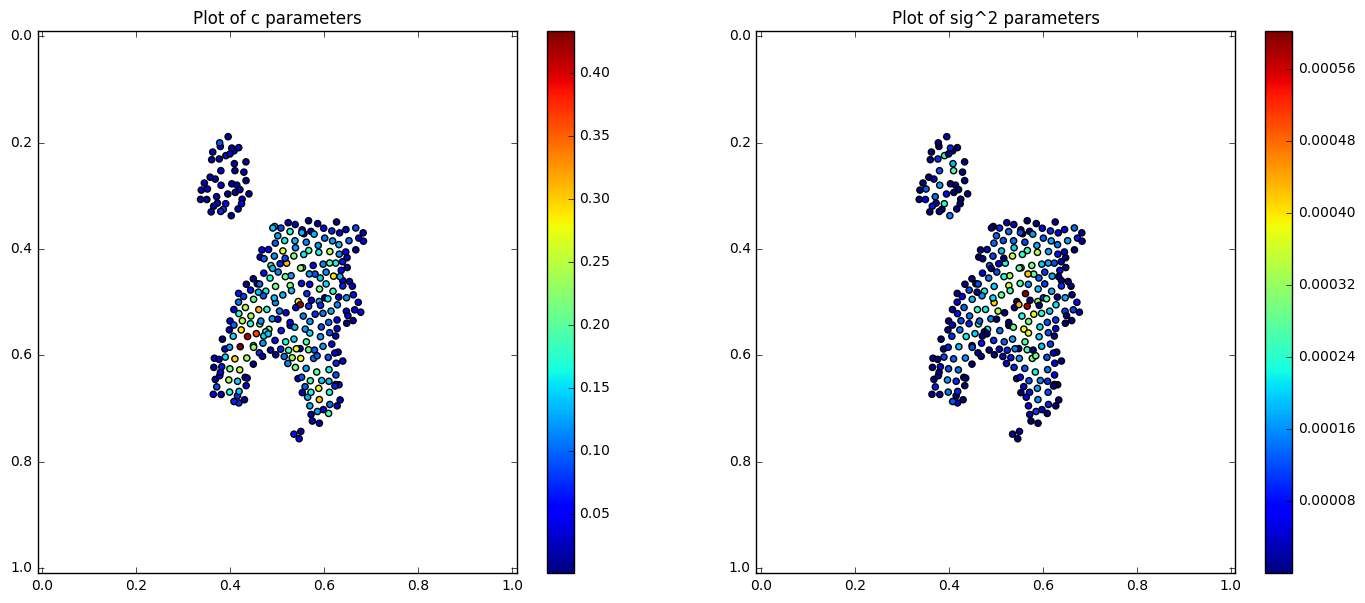

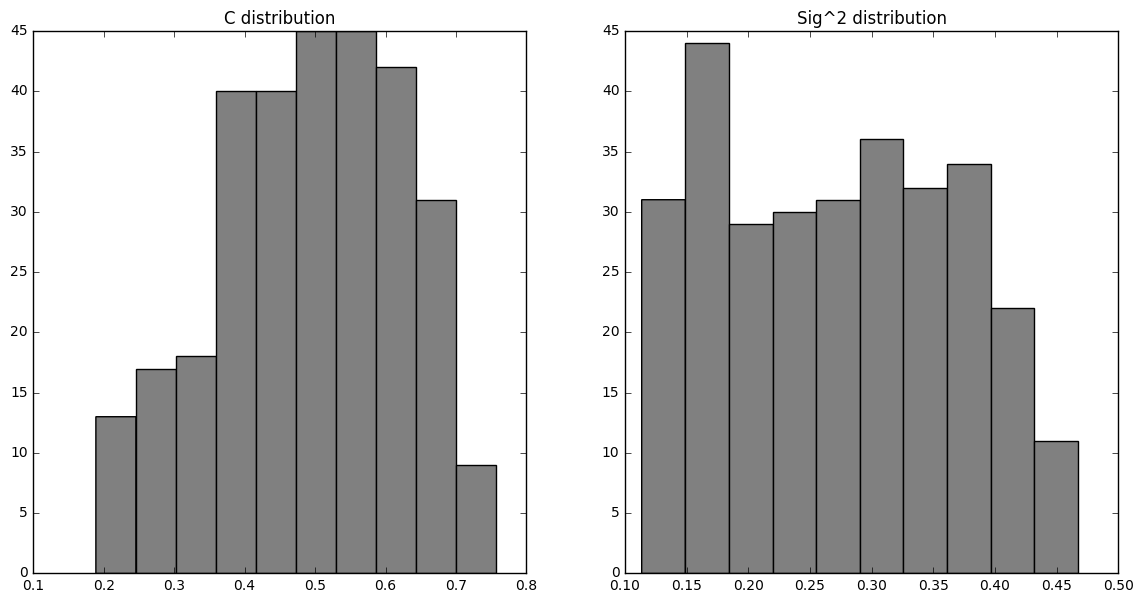

In [19]:
solution_plot(dfunc, sol.x[2*Nc:3*Nc], sol.x[3*Nc:4*Nc], sol.x[0:Nc], sol.x[Nc:2*Nc], dims=data.shape, base_level=base_level, compact_supp=True, square_c=False)
params_plot(sol.x[2*Nc:3*Nc], sol.x[3*Nc:4*Nc], sol.x[0:Nc], sol.x[Nc:2*Nc], square_c=False)
params_distribution_plot(sol.x[0:Nc], sol.x[Nc:2*Nc], square_c=False)